[View in Colaboratory](https://colab.research.google.com/github/sthalles/blog-resources/blob/master/sagan/Eager_SAGAN.ipynb)

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from keras.datasets import cifar10


1.9.0-rc2


Using TensorFlow backend.


In [2]:
# x_train, x_test: uint8 array of RGB image data with shape (num_samples, 3, 32, 32).
# y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


Number of classes: 10


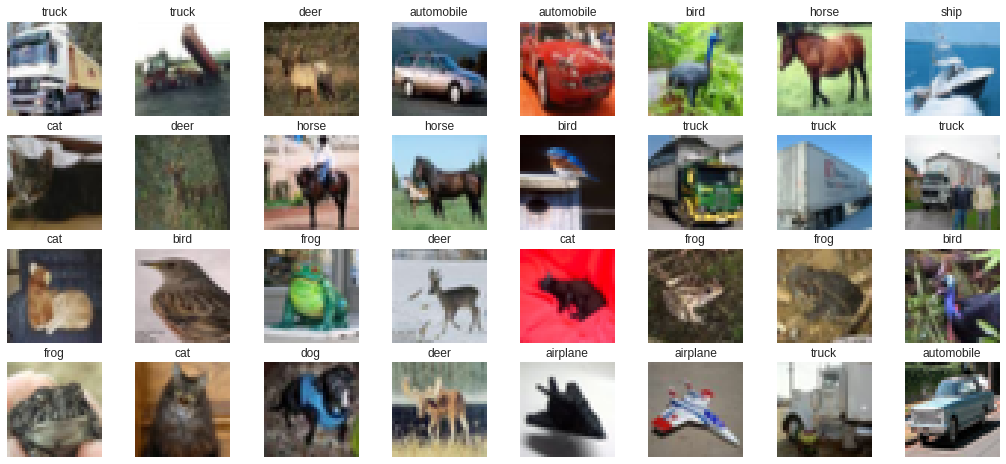

In [3]:
cifar_10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n_classes = len(cifar_10)
print("Number of classes:", n_classes)


fig = plt.figure(figsize=(18,8))
n_columns = 8
n_rows = 4

for i in range(1,n_columns*n_rows+1):
  fig.add_subplot(n_rows, n_columns, i)
  plt.imshow(X_train[i])
  plt.title(cifar_10[y_train[i]])
  # Turn off tick labels
  plt.xticks([])
  plt.yticks([])
plt.show()

In [4]:
tfe = tf.contrib.eager

In [5]:
# class SpectralNormalization(tf.keras.Model):
#   def __init__(self):
#     self.u = tfe.Variable(tf.)

SyntaxError: ignored

In [6]:
class SelfAttention(tf.keras.Model):
  def __init__(self, number_of_filters):
    super(SelfAttention, self).__init__(number_of_filters)
    
    self.f = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.g = tf.keras.layers.Conv2D(number_of_filters//8, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.h = tf.keras.layers.Conv2D(number_of_filters, 1, 
                                     strides=1, padding='SAME', 
                                     activation=None)
    
    self.gamma = tfe.Variable(0.0, dtype=tf.float32) 
    self.flatten = tf.keras.layers.Flatten()
    
  def call(self, x):
    input_shape = tf.shape(x)
    f = self.f(x)
    g = self.g(x)
    h = self.h(x)
    
    f_flatten = self.flatten(f)
    g_flatten = self.flatten(g)
    h_flatten = self.flatten(h)
    
#     print("f_flatten:", f_flatten.shape)
#     print("g_flatten:", g_flatten.shape)
#     print("h_flatten:", h_flatten.shape)
    
    s = tf.matmul(g_flatten, f_flatten, transpose_b=True)
    B = tf.nn.softmax(s)
    
#     print("s:",s.shape)
#     print("B:",B.shape)
    o = tf.matmul(B, h_flatten)
    
    y = self.gamma * o + self.flatten(x)
    return tf.reshape(y, input_shape)

In [7]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # define the generator's layers
    
    self.fc1 = tf.keras.layers.Dense(units=4*4*512, activation=None)
    
    # BN + ReLU
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation1 = tf.keras.layers.Activation(activation='relu')
    
    # Deconvolution layer. Resulting image shape: (batch, 8, 8, 256)
    self.transp_conv1 = tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2= tf.keras.layers.Activation(activation='relu')
    
    # resulting shape: (batch, 16, 16, 128)
    self.transp_conv2 = tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3= tf.keras.layers.Activation(activation='relu')
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(128)
    
    # resulting shape: (batch, 32, 32, 3)
    self.transp_conv3 = tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding="SAME", activation=None)
    self.out = tf.keras.layers.Activation(activation='tanh')
    
  def call(self,z, is_training):

    fc1 = self.fc1(z)
    fc1_reshaped = tf.reshape(fc1, (-1,4,4,512))

    bn1 = self.bn1(fc1_reshaped, training=is_training)
    activation1 = self.activation1(bn1)

    trans_conv1 = self.transp_conv1(activation1) # output shape [None,8,8,256]
    bn2 = self.bn2(trans_conv1, training=is_training)
    activation2 = self.activation2(bn2)

    transp_conv2 = self.transp_conv2(activation2) # output shape [None,16,16,128]
    bn3 = self.bn3(transp_conv2, training=is_training)
    activation3 = self.activation3(bn3)
    
    attention = self.attention(activation3)
    
    transp_conv3 = self.transp_conv3(attention) # output shape [None,32,32,3]
    output = self.out(transp_conv3)
    
    return output

In [8]:
class Discriminator(tf.keras.Model):
  def __init__(self, alpha):
    super(Discriminator, self).__init__()
    
    self.conv1 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='SAME', activation=None)
    print(self.conv1.shape)
    
    self.activation1 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # pass the number of filters of the current feature volume
    self.attention = SelfAttention(64)
  
    self.conv2 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='SAME', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.conv3 = tf.keras.layers.Conv2D(256, 5, strides=2, padding='SAME', activation=None)
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(units=1, activation=None)
    self.out = tf.keras.layers.Activation(activation='sigmoid')
  
  def call(self, inputs, is_training):

    conv1 = self.conv1(inputs)
    print(conv1.shape)
    activation1 = self.activation1(conv1)
    
    attention = self.attention(activation1)
    
    conv2 = self.conv2(activation1)
    bn1 = self.bn1(conv2, training=is_training)
    activation2 = self.activation2(bn1)
    
    conv3 = self.conv3(activation2)
    bn2 = self.bn2(conv3, training=is_training)
    activation3 = self.activation3(bn2)
    
    flat = self.flatten(activation3)
    logits = self.fc1(flat)
    out = self.out(logits)
    return out, logits

In [9]:
z_size = 100
learning_rate_generator = 0.0001
learning_rate_discriminator = 0.0004
batch_size = 128
alpha = 0.1
beta1 = 0.0
beta2 = 0.9

In [10]:
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

In [11]:
def generator_loss(d_logits_fake):
  return - tf.reduce_mean(d_logits_fake)

In [12]:
def discriminator_loss(d_logits_real, d_logits_fake):
  return tf.reduce_mean(- tf.minimum(0, -1. + d_logits_real)) - tf.reduce_mean(tf.minimum(0, -1. - d_logits_fake))

In [13]:
global_counter = tf.train.get_or_create_global_step()
generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_generator, beta1=beta1, beta2=beta2)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator, beta1=beta1, beta2=beta2)

In [14]:
def normalizer(image, label):
  image = 2 * tf.to_float(image) / 255.0 - 1.0
  return image, label

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(normalizer)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)

In [16]:
def display_images(dataset, figsize=(6,6), denomalize=True):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

tf.Tensor(
[[[[-3.17175746e-01 -1.63376689e-01 -9.83544067e-02 ... -6.61883652e-02
     3.16665252e-03 -8.99639428e-02]
   [-4.09988612e-01 -1.08104095e-01 -1.06532246e-01 ...  6.18944764e-02
    -1.25415906e-01 -9.76927057e-02]
   [-4.14243191e-01 -1.06026925e-01 -1.04699261e-01 ...  6.45507649e-02
    -1.27920553e-01 -9.74122509e-02]
   ...
   [-3.71489435e-01 -1.20862462e-01 -1.20953344e-01 ...  5.81893437e-02
    -1.12102695e-01 -8.36574435e-02]
   [-3.60814124e-01 -1.20687626e-01 -1.26094326e-01 ...  6.07723370e-02
    -1.13230616e-01 -8.28780681e-02]
   [-2.27653444e-01  7.88322538e-02 -1.02250807e-01 ...  4.00812440e-02
    -1.49881318e-01  6.52135117e-03]]

  [[-2.62008727e-01 -1.79219708e-01  4.80055809e-02 ... -9.24387127e-02
     9.50896442e-02 -1.47921726e-01]
   [-3.16932529e-01 -1.24579266e-01  7.11557940e-02 ...  4.47395481e-02
    -5.72370403e-02 -1.77175701e-01]
   [-3.21582675e-01 -1.22152396e-01  7.40191564e-02 ...  4.60950509e-02
    -6.03616834e-02 -1.76398203e-01]

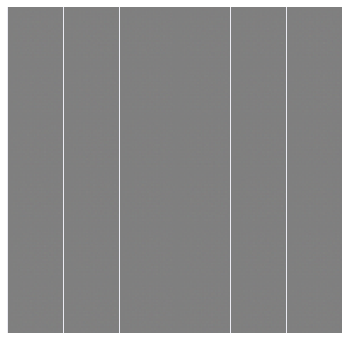

tf.Tensor(
[[[[-1.65059343e-02 -1.43269598e-01 -7.88543522e-02 ... -1.40265413e-02
     2.03478709e-02 -2.50219051e-02]
   [-4.61076275e-02 -9.90469083e-02 -1.40245736e-01 ...  1.97987491e-03
    -4.53438535e-02 -1.70972198e-02]
   [-6.38049841e-02 -1.06900193e-01 -9.80410874e-02 ...  5.00376895e-02
    -6.68975860e-02 -6.07914776e-02]
   ...
   [ 2.61849612e-01 -6.21521845e-03 -8.75740126e-02 ... -8.05927441e-03
     6.17778450e-02  6.96980804e-02]
   [ 3.43578279e-01 -7.91033804e-02 -5.45671657e-02 ... -1.35442996e-02
     8.77513438e-02  7.03686178e-02]
   [ 2.64864057e-01 -9.37103555e-02 -1.16350763e-02 ... -2.13152878e-02
     3.29889990e-02 -1.22094885e-01]]

  [[ 1.01957627e-01 -1.31861836e-01 -9.27551463e-02 ... -9.82120400e-04
     1.44928664e-01 -5.64244902e-03]
   [ 1.14395775e-01 -7.39004090e-02 -1.35251731e-01 ... -3.81736867e-02
     7.97846839e-02 -7.37436339e-02]
   [ 5.12526073e-02 -1.34522662e-01 -9.11480859e-02 ... -7.69394776e-03
     1.96511839e-02 -9.70336795e-02]

tf.Tensor(
[[[[-6.39804125e-01  2.83221155e-02  5.82619011e-02 ... -1.02350667e-01
    -1.30860016e-01 -2.47129321e-01]
   [-8.48126233e-01  8.92930254e-02  1.14075236e-01 ...  8.59586224e-02
    -2.55993426e-01 -1.35765538e-01]
   [-7.77519703e-01  1.39654234e-01  1.61704078e-01 ...  4.22515161e-02
    -2.05969796e-01 -5.67968711e-02]
   ...
   [-4.55124438e-01  1.28566802e-01 -2.27856804e-02 ... -2.01366004e-03
    -2.08497599e-01 -1.87265920e-03]
   [-4.06483412e-01 -1.07382551e-01 -3.04524079e-02 ...  1.14958165e-02
    -1.31079093e-01 -1.49583519e-01]
   [-4.12698478e-01  2.64692247e-01 -2.56704800e-02 ... -1.67341918e-01
     2.01181993e-02  1.45646349e-01]]

  [[-5.24308443e-01 -1.81943879e-01  3.40581387e-01 ... -1.10692680e-01
    -1.06600001e-01 -3.64940822e-01]
   [-6.89220190e-01 -1.58895105e-01  4.24962610e-01 ...  6.32176995e-02
    -2.81380206e-01 -2.49815464e-01]
   [-6.42245948e-01 -1.34787790e-03  3.57434034e-01 ... -2.03040391e-02
    -3.32173109e-01 -1.53079093e-01]

tf.Tensor(
[[[[ 1.50155395e-01 -1.41635453e-02 -2.62228772e-02 ...  3.18314619e-02
     8.50326866e-02  3.58467398e-04]
   [ 1.24343708e-01  7.63434693e-02 -7.19763115e-02 ... -7.12212995e-02
     4.74725403e-02 -9.29731429e-02]
   [ 6.76657483e-02  7.23984241e-02  5.92726469e-03 ... -3.89693072e-03
     1.11479633e-01  3.44282649e-02]
   ...
   [ 9.41738114e-02  6.75942563e-03 -2.23842725e-01 ... -1.03569165e-01
     1.83108523e-02  1.84845626e-01]
   [ 2.63688415e-01 -5.47614060e-02 -3.76921035e-02 ... -4.61186050e-03
     1.30435631e-01  4.37000394e-02]
   [ 2.08341986e-01 -6.79866150e-02 -1.55694336e-02 ... -1.22122787e-01
     6.06599674e-02 -1.02027796e-01]]

  [[ 2.06889987e-01 -3.55973989e-02 -5.11892661e-02 ...  2.15239413e-02
     5.97487390e-02  1.04965851e-01]
   [ 2.96686351e-01  5.65870889e-02 -6.75459728e-02 ... -1.10887177e-01
     7.70775601e-02 -8.18882585e-02]
   [ 1.07428417e-01  9.19663459e-02 -7.13148937e-02 ... -8.65972266e-02
     3.10298558e-02  5.62362038e-02]

tf.Tensor(
[[[[-2.26511285e-01 -7.03046620e-02 -1.40293211e-01 ... -7.45854527e-02
     4.71774228e-02  1.45018389e-02]
   [-5.02788723e-02 -2.11750437e-02 -1.93333104e-01 ... -1.42482877e-01
     6.68024421e-02 -7.14468732e-02]
   [-6.99668750e-02 -2.01889798e-02 -1.99637443e-01 ... -1.30799755e-01
     6.71305135e-02 -6.70666918e-02]
   ...
   [ 1.79507118e-02 -1.13483667e-02 -2.23429471e-01 ... -1.67767391e-01
     1.05180323e-01 -6.51668757e-02]
   [ 2.57496741e-02 -3.94857414e-02 -2.68020302e-01 ... -1.33891091e-01
     9.24283192e-02 -7.14143217e-02]
   [ 1.61559470e-02  6.53749406e-02 -2.01877564e-01 ... -2.85647452e-01
     2.49799136e-02 -5.99676333e-02]]

  [[-8.74492750e-02  3.42465751e-02 -7.29659721e-02 ...  1.29306419e-02
     6.86064363e-03  1.79734647e-01]
   [ 1.30563453e-01  6.45917431e-02  1.23498114e-02 ... -3.94290984e-02
     1.07034385e-01  8.43710080e-03]
   [ 1.29044786e-01  7.72227198e-02  2.44132653e-02 ... -3.29469964e-02
     8.58225524e-02  4.06945683e-03]

tf.Tensor(
[[[[ 3.53914469e-01  3.53546552e-02 -2.27548648e-03 ...  6.93920329e-02
     4.79367040e-02  1.41732559e-01]
   [ 4.64991629e-01  7.14644883e-03  1.20651470e-02 ... -3.41276526e-02
     1.43927887e-01  8.01199824e-02]
   [ 4.28876579e-01 -4.23866138e-03  2.35907063e-02 ... -1.58682149e-02
     9.79478285e-02  7.05485744e-03]
   ...
   [ 4.20906126e-01 -1.35395713e-02 -2.44996394e-03 ... -3.64919305e-02
     1.29125670e-01  7.24473000e-02]
   [ 4.11675245e-01 -1.67986695e-02 -3.74924246e-04 ... -3.41640040e-02
     1.24067701e-01  6.43910989e-02]
   [ 2.78573960e-01 -1.05148509e-01  3.70892473e-02 ... -1.29541103e-02
     7.27501288e-02 -7.62942210e-02]]

  [[ 2.28017271e-01  1.28101870e-01 -1.47653520e-01 ...  8.52939114e-02
     8.35976750e-03  1.91390172e-01]
   [ 2.12879419e-01  1.75309688e-01 -1.94546685e-01 ...  3.05317733e-02
     1.82670187e-02  6.71780109e-02]
   [ 1.28748775e-01  2.86016822e-01  7.84878358e-02 ...  1.39804799e-02
     2.21151989e-02  7.22571509e-03]

tf.Tensor(
[[[[ 3.93807113e-01 -4.84022638e-03 -8.53895769e-03 ...  8.44673216e-02
     6.12472259e-02  1.52264506e-01]
   [ 5.59070110e-01 -1.24397799e-02 -3.07148267e-02 ... -6.55192286e-02
     2.20168307e-01  7.60811120e-02]
   [ 4.70918179e-01 -7.55167529e-02 -7.07767755e-02 ...  3.16531882e-02
     1.02360241e-01  4.19721976e-02]
   ...
   [-1.75822735e-01 -4.99211214e-02 -1.56203553e-01 ... -1.39865056e-01
    -2.56467294e-02 -7.75236934e-02]
   [-2.54386842e-01 -1.62886947e-01 -1.51763201e-01 ...  6.58653677e-02
    -5.40477000e-02  1.32711986e-02]
   [-1.88810393e-01 -4.87306044e-02 -1.54085591e-01 ... -5.30876108e-02
    -2.00819954e-01 -1.70072149e-02]]

  [[ 1.90142676e-01  1.48124442e-01 -2.15627745e-01 ...  3.52316201e-02
     8.78034346e-03  1.52871370e-01]
   [ 2.12017581e-01  2.42200956e-01 -1.55220821e-01 ... -2.38538347e-02
     1.64503813e-01  1.92571998e-01]
   [ 2.28697389e-01  8.62849653e-02 -1.48918480e-01 ...  7.95681253e-02
     1.09138004e-01  7.44015351e-02]

tf.Tensor(
[[[[ 3.89933169e-01  2.54778210e-02 -1.87212862e-02 ...  2.33756751e-02
     1.58924982e-01  1.98005557e-01]
   [ 4.39381838e-01 -8.28079432e-02  3.75154465e-02 ...  1.02711879e-01
     2.52452850e-01  4.84984852e-02]
   [ 3.89790595e-01 -1.24958307e-01 -1.52600840e-01 ... -1.06413625e-01
     1.35259286e-01 -4.63356748e-02]
   ...
   [ 5.57571054e-01 -1.52415363e-03 -2.68803108e-02 ...  1.86080690e-02
     1.76810756e-01  5.70875630e-02]
   [ 4.89015579e-01  6.39631972e-02  3.53959762e-02 ... -3.38700861e-02
     1.15623519e-01 -1.36943879e-02]
   [ 3.61002326e-01 -1.16596393e-01  8.39603916e-02 ...  1.96750332e-02
     1.38057292e-01 -6.29081577e-02]]

  [[ 1.46152735e-01  1.00063086e-01 -1.41572908e-01 ...  3.36273238e-02
     1.03207260e-01  3.24556738e-01]
   [ 3.61112595e-01  7.79347271e-02 -1.94933370e-01 ...  7.49707222e-02
     1.17342420e-01  1.90549389e-01]
   [ 5.80222368e-01  6.66768923e-02 -2.62605429e-01 ... -7.48175010e-02
     2.32701257e-01  1.06036447e-01]

tf.Tensor(
[[[[-4.25553083e-01  1.03625208e-02  2.21505053e-02 ... -6.60252869e-02
    -1.03674136e-01 -1.91604942e-01]
   [-6.02626264e-01  7.97142759e-02  5.89474849e-02 ... -1.29321162e-02
    -1.74855843e-01 -1.31343216e-01]
   [-5.27091622e-01  2.03213006e-01  5.73141053e-02 ... -7.47845620e-02
    -1.95384756e-01  4.76402082e-02]
   ...
   [-3.81918848e-01  1.55122560e-02 -8.36949609e-03 ... -7.40914941e-02
    -8.49582776e-02 -8.68305638e-02]
   [-4.53642428e-01  4.04626057e-02  3.63032594e-02 ...  1.85415763e-02
    -1.39385596e-01 -7.99418017e-02]
   [-3.33036929e-01  1.38036191e-01 -1.78358313e-02 ... -7.68555328e-04
    -5.86243346e-02  9.75219086e-02]]

  [[-3.59076768e-01 -1.12270847e-01  2.14435220e-01 ... -9.74840969e-02
    -7.18736276e-02 -2.42941692e-01]
   [-4.62680936e-01 -9.85714272e-02  2.93397605e-01 ... -7.85654131e-03
    -1.35154024e-01 -1.35433137e-01]
   [-3.82354110e-01 -2.29016915e-02  8.07126313e-02 ...  2.14767046e-02
    -2.18132034e-01  1.57712456e-02]

tf.Tensor(
[[[[-2.80906856e-01 -4.72553819e-02 -4.51108925e-02 ... -7.65253976e-02
    -3.73835117e-02 -5.50494120e-02]
   [-2.66868442e-01 -4.05507311e-02 -4.57292162e-02 ... -4.95859347e-02
    -4.99494523e-02 -3.34192924e-02]
   [-2.38502622e-01 -3.83836292e-02 -9.89222899e-02 ... -6.24044426e-02
    -4.76245843e-02 -5.94276786e-02]
   ...
   [-4.23376471e-01  3.23565640e-02 -7.71401674e-02 ... -2.15719193e-02
    -1.69102192e-01 -1.83182225e-01]
   [-5.18222988e-01  1.02011941e-01 -3.02454364e-03 ... -2.12398488e-02
    -1.59116656e-01 -1.44537508e-01]
   [-3.62055629e-01  2.08813831e-01 -5.26712351e-02 ... -6.67837411e-02
    -5.15730493e-02  1.17075421e-01]]

  [[-3.47975791e-01  9.32519212e-02  3.22811678e-02 ... -4.64223996e-02
    -6.92033023e-02 -5.67022935e-02]
   [-3.78103673e-01  1.65772676e-01  1.66427359e-01 ...  5.14608361e-02
    -5.86373657e-02 -3.16837169e-02]
   [-3.84859204e-01  1.26982778e-01  2.13122159e-01 ...  7.85892382e-02
    -6.05482683e-02 -3.40299979e-02]

tf.Tensor(
[[[[-3.64189297e-01 -1.46071970e-01 -1.01674825e-01 ... -5.76700903e-02
     9.17556435e-02  4.15301137e-02]
   [-2.21013770e-01 -2.21368268e-01 -3.05477053e-01 ... -2.14154646e-02
    -8.76782313e-02 -6.93643764e-02]
   [-1.27940238e-01 -1.96462899e-01 -3.83751661e-01 ... -1.55730113e-01
    -2.83363368e-02 -1.17012575e-01]
   ...
   [-3.11389983e-01 -2.62513578e-01 -1.80585578e-01 ...  5.08106388e-02
    -1.34467468e-01  3.62312049e-02]
   [-9.79978070e-02 -2.81616330e-01 -2.91956246e-01 ... -1.44266829e-01
     2.06218772e-02 -7.51829371e-02]
   [-1.78708375e-01 -4.83735017e-02 -2.80380219e-01 ... -1.87547550e-01
    -1.74226180e-01 -2.28694780e-03]]

  [[ 1.41161427e-01 -1.52233958e-01 -1.16460763e-01 ... -5.66644147e-02
     4.03692126e-02  1.84481926e-02]
   [ 5.34916878e-01 -2.24692658e-01 -6.96593225e-02 ... -1.11500762e-01
     9.18624923e-02  4.76441160e-02]
   [ 4.65833277e-01 -2.90673256e-01  1.35354325e-01 ... -2.57681329e-02
     1.99385539e-01 -1.16167314e-01]

tf.Tensor(
[[[[-6.36997938e-01  1.22582227e-01 -5.92629937e-03 ... -2.27089062e-01
    -9.16482657e-02 -9.69800949e-02]
   [-5.69638610e-01 -1.22273304e-01 -1.30184330e-02 ...  1.31626680e-01
    -1.03540063e-01  1.76310286e-01]
   [-2.50943005e-01 -7.72610605e-02 -4.74587716e-02 ...  2.58963089e-02
    -2.03088466e-02 -2.29483947e-01]
   ...
   [-8.70882750e-01  1.07556894e-01  6.49622902e-02 ...  6.03321008e-03
    -2.54636467e-01 -1.54109105e-01]
   [-9.19614613e-01  1.10240087e-01  9.66482013e-02 ...  4.38819081e-02
    -2.71301955e-01 -1.52363658e-01]
   [-6.84755981e-01  2.84763843e-01 -8.29368737e-03 ...  8.06791894e-03
    -9.19569060e-02  2.04429612e-01]]

  [[-3.20913911e-01 -2.96223104e-01 -6.41328320e-02 ... -1.22829080e-01
     3.85880060e-02 -7.75042772e-02]
   [-1.58307582e-01 -2.84817219e-01 -1.61317110e-01 ...  4.00548335e-03
    -1.36064529e-01  4.42303903e-02]
   [ 7.63953328e-02 -2.51902163e-01 -1.99587699e-02 ... -1.05878366e-02
     7.78791234e-02 -9.92189944e-02]

tf.Tensor(
[[[[-6.82694554e-01  3.60969082e-02  2.91626640e-02 ... -1.18362434e-01
    -1.36469945e-01 -2.65523076e-01]
   [-8.76562834e-01  9.87924412e-02  6.95839003e-02 ...  3.32765542e-02
    -2.47971416e-01 -1.28909558e-01]
   [-8.08436632e-01  8.28414559e-02  5.39460965e-02 ...  4.41284738e-02
    -2.26237670e-01 -9.24969986e-02]
   ...
   [-8.08197558e-01  8.10038671e-02  7.22455531e-02 ...  4.23946157e-02
    -2.30286613e-01 -1.44472554e-01]
   [-8.06538045e-01  7.80558214e-02  7.08655939e-02 ...  4.47231792e-02
    -2.30591223e-01 -1.47754550e-01]
   [-5.87903321e-01  2.37759680e-01 -9.08428989e-03 ...  1.06775230e-02
    -8.65092352e-02  1.55248597e-01]]

  [[-5.34005225e-01 -1.87625214e-01  2.66108185e-01 ... -1.18746221e-01
    -1.12516120e-01 -3.70049685e-01]
   [-6.81634784e-01 -1.44677669e-01  3.01260740e-01 ...  5.23243612e-03
    -2.75262982e-01 -2.35622808e-01]
   [-6.59631252e-01 -1.24813311e-01  2.83340663e-01 ...  2.82499362e-02
    -2.55437374e-01 -1.96165293e-01]

tf.Tensor(
[[[[ 2.04240769e-01  2.45971773e-02  2.21253727e-02 ...  4.23286371e-02
     3.50367837e-02  7.67254531e-02]
   [ 2.55810112e-01  1.60307251e-03  1.60386395e-02 ... -1.04917381e-02
     7.88697526e-02  4.59708422e-02]
   [ 2.49496683e-01  6.53197011e-03  2.03256160e-02 ... -1.41591148e-03
     7.84370527e-02  3.99425812e-02]
   ...
   [ 1.30172163e-01  2.65502278e-02  3.28326710e-02 ... -9.11510177e-03
     5.03417924e-02  2.32393015e-02]
   [ 1.26044363e-01  2.02486385e-02  3.18749212e-02 ... -1.42351724e-04
     4.41837907e-02  3.04439254e-02]
   [ 9.33790728e-02 -3.35063003e-02  3.35867777e-02 ... -1.37188183e-02
     5.04698344e-02 -1.18340598e-02]]

  [[ 1.58298343e-01  6.79134279e-02 -5.74526340e-02 ...  3.83347422e-02
     7.19355140e-03  1.00761771e-01]
   [ 1.90836594e-01  5.91318943e-02 -7.58265555e-02 ... -8.52956995e-03
     6.41167536e-02  8.14979896e-02]
   [ 1.70544192e-01  5.70691675e-02 -7.17476383e-02 ... -2.29336470e-02
     6.17681891e-02  6.81106895e-02]

tf.Tensor(
[[[[-6.02236331e-01  3.69146019e-02 -3.99684235e-02 ... -1.48996726e-01
    -8.45422223e-02 -1.41511649e-01]
   [-6.82710588e-01  3.98898274e-02  4.55895625e-02 ...  8.06219429e-02
    -2.25910440e-01 -1.34560257e-01]
   [-7.30670452e-01  7.55046904e-02  1.11419104e-01 ...  8.28613807e-03
    -1.85380071e-01 -2.36372337e-01]
   ...
   [-7.22580016e-01  9.18109119e-02  1.40825436e-01 ... -7.69826397e-02
    -1.49757251e-01 -2.07315311e-01]
   [-7.67327666e-01 -2.04320531e-02 -5.27524874e-02 ...  8.04179832e-02
    -1.92472562e-01 -7.31078908e-03]
   [-3.82542193e-01  2.48300672e-01 -4.97924052e-02 ... -4.26659174e-02
    -5.98952956e-02  7.28781298e-02]]

  [[-5.21161616e-01 -1.07699111e-01  1.47923321e-01 ... -1.02572240e-01
    -8.76996368e-02 -2.29321212e-01]
   [-5.96609712e-01 -1.47285521e-01  2.95217276e-01 ...  3.83337587e-02
    -2.47523665e-01 -2.60818362e-01]
   [-6.99433744e-01 -1.51571348e-01  3.47481936e-01 ... -2.31664106e-02
    -1.92155167e-01 -3.19617987e-01]

tf.Tensor(
[[[[ 2.32113451e-01 -1.26841562e-02  1.51634011e-02 ...  6.41468316e-02
     2.83826664e-02  5.97899519e-02]
   [ 2.43338823e-01 -4.05404828e-02 -6.55252673e-03 ... -1.18078608e-02
     7.80062973e-02  7.26805488e-03]
   [ 1.77836522e-01 -1.50467837e-02 -1.62770431e-02 ... -1.45775285e-02
     4.63943183e-02  1.62220057e-02]
   ...
   [ 1.85719393e-02 -1.51064191e-02 -1.67854354e-02 ... -1.56911951e-03
     4.91127791e-03  4.69432073e-03]
   [ 3.06842756e-02 -3.83147574e-03 -1.51132764e-02 ... -2.03248840e-02
     2.65939720e-03  5.02804411e-04]
   [ 4.13040891e-02 -2.71974076e-02  3.92266503e-03 ...  9.21312906e-03
    -2.79847742e-03  4.07757331e-03]]

  [[ 2.08953992e-01  3.57594527e-02 -6.33278638e-02 ...  4.93076518e-02
     2.82244384e-02  9.50081497e-02]
   [ 2.14189410e-01  9.21276119e-03 -8.91875327e-02 ... -1.97372250e-02
     8.51558298e-02  4.35297936e-02]
   [ 1.67481333e-01  2.40468178e-02 -6.15243949e-02 ... -1.92976724e-02
     5.46892881e-02  3.67950983e-02]

tf.Tensor(
[[[[-3.24329525e-01 -5.02137952e-02 -3.90590169e-02 ... -5.97552657e-02
    -3.66921723e-02 -1.18023105e-01]
   [-4.25351769e-01 -1.16504747e-02 -1.58247948e-02 ...  3.73730175e-02
    -1.16636112e-01 -9.79774594e-02]
   [-4.24288303e-01 -9.76669136e-03 -2.12604217e-02 ...  3.47209238e-02
    -1.25612378e-01 -1.06239155e-01]
   ...
   [-2.46447921e-01 -4.82907444e-02 -1.01751604e-04 ... -2.73766182e-02
    -1.37939919e-02 -1.28236249e-01]
   [-3.52776825e-01 -1.46358684e-02 -3.39703150e-02 ...  2.76324116e-02
    -1.08344994e-01 -8.66811648e-02]
   [-2.36282885e-01  9.59806517e-02 -3.08903791e-02 ...  2.54187360e-02
    -7.76029751e-02  2.78967600e-02]]

  [[-3.42731535e-01 -9.52482894e-02  7.28107318e-02 ... -7.67467543e-02
    -5.50439581e-04 -1.83264017e-01]
   [-4.27380562e-01 -6.36691004e-02  1.22064106e-01 ...  2.95703262e-02
    -1.09052598e-01 -1.64233908e-01]
   [-4.21008110e-01 -6.64887428e-02  1.22805834e-01 ...  2.54526325e-02
    -1.11795329e-01 -1.67479232e-01]

tf.Tensor(
[[[[-6.87237024e-01  6.54421747e-05  1.46243861e-02 ... -1.31020993e-01
    -1.28540218e-01 -2.75474161e-01]
   [-8.79000068e-01  3.67314368e-02  1.92289297e-02 ...  3.53469923e-02
    -2.70753652e-01 -1.85616776e-01]
   [-8.73569310e-01  3.37605625e-02  1.09306378e-02 ...  3.54743823e-02
    -2.73042232e-01 -1.90215901e-01]
   ...
   [-8.74932647e-01  3.20684612e-02  1.02042938e-02 ...  3.62416357e-02
    -2.74711549e-01 -1.89668149e-01]
   [-8.87608230e-01  3.14906836e-02 -5.52819856e-03 ...  4.54997569e-02
    -2.86182463e-01 -1.91749513e-01]
   [-6.64617121e-01  2.29624450e-01 -7.23709390e-02 ...  1.10240914e-02
    -1.35709971e-01  1.43786117e-01]]

  [[-7.88002647e-03 -5.54809809e-01  5.91468737e-02 ... -1.12150438e-01
     1.39672473e-01 -1.46054983e-01]
   [ 1.94213390e-01 -5.81984043e-01 -1.49878144e-01 ... -2.44646147e-01
     1.22276843e-02 -9.45116356e-02]
   [ 2.28614092e-01 -5.54438591e-01 -1.24440096e-01 ... -2.78696984e-01
     3.10210679e-02 -1.18867137e-01]

tf.Tensor(
[[[[-1.34017870e-01 -1.73228774e-02 -1.02104507e-02 ... -2.31397040e-02
    -8.55534896e-03 -4.59508598e-02]
   [-1.78073764e-01 -9.20992112e-04 -5.48110530e-03 ...  3.68805905e-03
    -3.70572992e-02 -5.18547632e-02]
   [-1.93026036e-01  3.74780130e-03 -2.76333466e-03 ...  6.28559524e-03
    -4.69285250e-02 -5.81346005e-02]
   ...
   [-2.61839032e-01  1.59963593e-02  3.30234994e-03 ...  1.12599414e-02
    -5.88457882e-02 -6.71377108e-02]
   [-2.66833484e-01  1.77603085e-02  6.02533063e-03 ...  2.68128584e-03
    -6.21274896e-02 -6.42210469e-02]
   [-1.81677431e-01  4.69284803e-02 -1.69922579e-02 ... -2.39730952e-03
    -3.48911807e-02  4.61339988e-02]]

  [[-1.16740450e-01 -2.09477432e-02  4.68095765e-02 ... -3.20084356e-02
    -1.47807261e-03 -6.32168800e-02]
   [-1.44427389e-01 -1.63027458e-02  6.81615174e-02 ... -1.42104253e-02
    -3.17769796e-02 -6.40652925e-02]
   [-1.64571330e-01 -2.48440579e-02  7.36279562e-02 ... -1.09693063e-02
    -3.92524935e-02 -7.27188215e-02]

tf.Tensor(
[[[[ 1.45086914e-01 -1.59816314e-02  1.43174399e-02 ...  4.31271493e-02
    -4.32370463e-03  2.38495599e-02]
   [ 1.66093722e-01 -1.02520473e-02 -1.82766356e-02 ... -2.18918510e-02
     5.90762682e-02  6.10523485e-02]
   [ 1.94181979e-01 -3.44011784e-02  1.58293322e-02 ... -1.04886219e-02
     4.58412170e-02  3.74269933e-02]
   ...
   [ 2.40438655e-01 -6.28927425e-02 -4.59258109e-02 ... -3.57776321e-02
     1.31975502e-01  3.83108668e-02]
   [ 2.44811922e-01 -4.04059850e-02 -8.76402855e-02 ... -1.50213223e-02
     1.37271404e-01  8.38670041e-03]
   [ 1.72023401e-01 -1.51734734e-02  4.82193604e-02 ... -2.64192056e-02
     5.21347560e-02 -7.69990236e-02]]

  [[ 1.24512203e-01  6.48296438e-03 -4.31659408e-02 ...  2.29740161e-02
     1.05256145e-03  3.08013447e-02]
   [ 1.29435584e-01  5.96310869e-02 -7.31818751e-02 ...  4.38456191e-05
     6.28210530e-02  8.78426135e-02]
   [ 1.51785895e-01  2.45175678e-02 -6.31856099e-02 ... -1.49925053e-03
     7.73088112e-02  7.28586316e-02]

tf.Tensor(
[[[[ 1.74024031e-01  6.70098811e-02  3.19070481e-02 ...  3.81932072e-02
     1.23018093e-01  8.36904421e-02]
   [ 2.24658057e-01  1.24659225e-01  4.75285873e-02 ... -3.14252749e-02
     1.76627159e-01  4.37791534e-02]
   [ 2.68952072e-01  4.08792347e-02  7.88486972e-02 ... -1.70682631e-02
     2.29679778e-01  4.43658307e-02]
   ...
   [ 6.74104035e-01 -1.09950043e-01 -4.13421057e-02 ...  1.72036543e-01
     1.66463554e-01  2.04547361e-01]
   [ 4.75419283e-01 -1.08709382e-02  1.27787158e-01 ... -5.67401946e-02
    -4.41903342e-03 -3.29907149e-01]
   [-1.10303216e-01  6.50303289e-02  1.07774541e-01 ...  5.29631674e-02
     7.83966333e-02  5.10173850e-02]]

  [[ 1.02931850e-01  1.69401869e-01  3.49429250e-02 ... -9.85144172e-04
     3.46979834e-02  1.16482295e-01]
   [ 4.05774862e-02  1.92729548e-01  4.66703773e-02 ...  6.37904648e-03
     1.13232061e-01  5.99491596e-02]
   [ 4.88405600e-02  1.51574701e-01  1.76970121e-02 ... -4.29824926e-02
     1.14684761e-01  6.34925440e-02]

tf.Tensor(
[[[[ 6.27057374e-01 -4.49780189e-02  1.03460941e-02 ...  9.93309617e-02
     1.12117708e-01  2.30498180e-01]
   [ 7.64240623e-01 -1.04507051e-01 -8.44187289e-02 ... -2.43699104e-02
     2.10549653e-01  1.97153181e-01]
   [ 8.06674778e-01 -7.12375045e-02 -5.57122007e-02 ... -5.77637590e-02
     2.23160729e-01  1.71430409e-01]
   ...
   [ 7.77935624e-01 -1.27483442e-01 -1.10047400e-01 ... -6.26759455e-02
     2.01124296e-01  1.27832100e-01]
   [ 7.08606839e-01 -2.90750973e-02 -2.07979176e-02 ... -6.03675283e-02
     1.83686212e-01  1.56646490e-01]
   [ 4.54015285e-01 -2.64096230e-01  1.95488315e-02 ...  2.97627784e-02
     4.28953134e-02 -8.15022364e-02]]

  [[ 5.31812310e-01  1.11919418e-01 -2.29618728e-01 ...  6.85121715e-02
     1.13480717e-01  3.86756450e-01]
   [ 6.96578026e-01  1.12404950e-01 -3.02345157e-01 ...  6.35074568e-04
     2.55031675e-01  2.82328427e-01]
   [ 6.75541341e-01  1.44876987e-01 -3.18057656e-01 ... -2.84550129e-03
     2.26177275e-01  2.53687650e-01]

tf.Tensor(
[[[[-7.34915912e-01  2.54606921e-02  9.65051819e-03 ... -9.90056247e-02
    -1.51787266e-01 -3.18496466e-01]
   [-9.64601636e-01  9.69316661e-02  6.05323128e-02 ...  4.18352857e-02
    -2.73357123e-01 -2.28186473e-01]
   [-9.72319007e-01  1.02346599e-01  7.10456222e-02 ...  3.97305153e-02
    -2.68904805e-01 -2.16751739e-01]
   ...
   [-2.36262098e-01 -1.01267219e-01 -1.98205039e-01 ... -2.03313068e-01
     2.64300555e-02 -1.71582058e-01]
   [-5.89878619e-01  1.08343549e-04 -4.69762944e-02 ... -3.76504585e-02
    -2.64447570e-01 -2.14512840e-01]
   [-5.12863636e-01  1.83071703e-01 -1.12909235e-01 ... -1.59269962e-02
    -9.84144285e-02  1.04723893e-01]]

  [[-2.38219276e-01 -3.42289716e-01  1.59832805e-01 ... -4.85689305e-02
    -2.01104861e-02 -3.96530479e-01]
   [-4.18179959e-01 -3.30109805e-01  1.06934905e-01 ... -7.16361776e-02
    -2.27505460e-01 -3.39759558e-01]
   [-5.97977579e-01 -2.80826569e-01  1.81522608e-01 ... -1.67350303e-02
    -2.87569046e-01 -3.26435983e-01]

tf.Tensor(
[[[[ 4.80380319e-02  1.41972825e-01  1.35900125e-01 ...  1.43744061e-02
    -1.09812524e-02  3.32326330e-02]
   [ 1.32077321e-01  1.22577831e-01  1.62100673e-01 ...  3.61105166e-02
     8.96222070e-02  1.11230515e-01]
   [ 1.97165385e-01  6.69560060e-02  1.34328216e-01 ...  1.26402853e-02
     1.14709474e-01  3.81460749e-02]
   ...
   [-9.24861968e-01  1.05455533e-01  7.78802410e-02 ... -8.42372142e-03
    -2.60823220e-01 -2.12330639e-01]
   [-9.30315197e-01  1.49323940e-01  9.09773260e-02 ... -3.61278094e-02
    -3.07523698e-01 -2.09940404e-01]
   [-6.37718320e-01  2.80457586e-01  3.21361460e-02 ...  4.80471216e-02
    -9.40407664e-02  2.18263045e-01]]

  [[-2.41562679e-01  2.17755020e-01  4.73301634e-02 ... -3.42298560e-02
    -1.46645248e-01 -1.98181067e-02]
   [-3.04439783e-01  2.47054666e-01  1.06154159e-01 ...  1.04351006e-01
    -1.33555651e-01  9.37574878e-02]
   [-1.27179042e-01  1.67832538e-01  1.46024734e-01 ...  6.53450415e-02
    -1.32769849e-02  9.68527645e-02]

tf.Tensor(
[[[[ 2.42100552e-01  1.09415479e-01  1.32681653e-01 ...  4.25503775e-02
     1.44758150e-01  9.13518965e-02]
   [ 2.79168129e-01  6.84201941e-02  3.60092595e-02 ... -4.04281430e-02
     1.83497250e-01  4.92402948e-02]
   [ 3.10048312e-01  8.13519955e-02  4.48250771e-02 ... -2.59608440e-02
     1.65178224e-01  2.36975476e-02]
   ...
   [ 2.71646917e-01  5.85689619e-02  5.21966554e-02 ... -5.22966795e-02
     1.66315839e-01  1.96896531e-02]
   [ 2.94983089e-01  8.13899934e-02  5.59716523e-02 ... -7.32940808e-02
     1.71568602e-01  6.57359585e-02]
   [ 2.17218727e-01 -1.01120509e-01  8.84464234e-02 ... -6.51122332e-02
     1.76534608e-01  2.75432058e-02]]

  [[ 2.47206509e-01  7.32119977e-02  1.93106029e-02 ... -4.96058166e-03
     1.54191442e-02  1.77823752e-01]
   [ 3.19188386e-01  6.31253049e-02 -6.70510978e-02 ... -9.30000022e-02
     1.21031880e-01  1.21784545e-01]
   [ 2.92953342e-01  7.00997263e-02 -4.77412157e-02 ... -1.07640132e-01
     1.38702199e-01  1.09115399e-01]

tf.Tensor(
[[[[-5.75545840e-02  3.55189592e-02  5.17631657e-02 ...  1.72430761e-02
    -4.47968813e-03 -2.26006135e-02]
   [-1.02257319e-01  7.42326379e-02  6.59984350e-02 ...  1.99821442e-02
    -1.55739123e-02 -4.25747745e-02]
   [-9.78517756e-02  9.94001478e-02  2.13287864e-02 ...  2.88994797e-02
    -3.07114534e-02  4.26617637e-02]
   ...
   [ 1.42264552e-02  1.07833050e-01  2.42129296e-01 ...  1.04700655e-01
    -2.46400535e-02  3.14820185e-02]
   [ 1.96105853e-01  4.54754718e-02  8.09122622e-02 ...  6.36612028e-02
     1.69548601e-01  1.59062058e-01]
   [ 2.53258765e-01 -9.23967436e-02  1.20698094e-01 ... -4.99777235e-02
     1.45453170e-01 -2.36622039e-02]]

  [[ 2.42596753e-02 -9.71984342e-02 -1.11523438e-02 ... -3.69630903e-02
     1.98117495e-02 -1.02733206e-02]
   [ 2.07314268e-02 -4.61939201e-02 -4.46569808e-02 ... -1.45588428e-01
    -2.42489092e-02 -5.99451065e-02]
   [-2.78376639e-02  5.69975469e-04 -1.55724823e-01 ... -4.18819897e-02
    -3.82023752e-02  1.01576649e-01]

tf.Tensor(
[[[[-7.54152477e-01  5.15640862e-02  3.43204923e-02 ... -1.74984932e-01
    -1.68462962e-01 -2.96979517e-01]
   [-6.20790005e-01  5.50909117e-02 -2.84730997e-02 ...  3.36312726e-02
     2.90520675e-02  1.77413151e-01]
   [-2.08610907e-01 -1.97398961e-01 -1.43985122e-01 ...  3.58843245e-02
    -1.01908986e-02  2.93262787e-02]
   ...
   [-3.08507115e-01 -1.89103633e-01 -2.95151442e-01 ... -1.28627449e-01
    -1.85838133e-01 -1.74133673e-01]
   [-4.14632082e-01  1.11911274e-01 -1.70913130e-01 ... -8.20108801e-02
    -1.20305791e-01 -1.29963174e-01]
   [-4.22421336e-01  2.79091328e-01  1.62732024e-02 ...  2.69258656e-02
    -9.73186791e-02  4.05877177e-03]]

  [[-6.68969929e-01 -1.33213341e-01  2.78335512e-01 ... -1.93618327e-01
    -1.73894718e-01 -4.10312653e-01]
   [-3.94263119e-01  1.54701471e-01  1.68657452e-01 ... -2.41778651e-03
    -7.43439794e-02  3.28847080e-01]
   [ 4.35971916e-01 -1.60464525e-01  1.98797524e-01 ...  1.84665069e-01
    -6.56180084e-04  2.76005596e-01]

tf.Tensor(
[[[[-1.80161923e-01 -1.84319511e-01 -1.27219915e-01 ... -4.68721725e-02
     1.05366353e-02 -8.42191800e-02]
   [-2.37098038e-01 -1.42086923e-01 -1.69936955e-01 ...  2.34515332e-02
    -1.08574815e-01 -1.04161836e-01]
   [-2.49165192e-01 -1.42621964e-01 -1.24576554e-01 ...  4.41556051e-02
    -1.08460896e-01 -1.36914015e-01]
   ...
   [-4.31249768e-01 -1.25587493e-01 -7.47895613e-02 ...  1.05239069e-02
    -9.22669619e-02 -7.29246289e-02]
   [-3.29630643e-01 -9.51095074e-02 -1.02685973e-01 ... -3.65316086e-02
    -1.21530011e-01 -1.05085202e-01]
   [-1.91789180e-01  2.61599384e-03 -1.35120556e-01 ...  3.57356332e-02
    -1.72156304e-01  8.64197128e-03]]

  [[-8.81900489e-02 -1.72059461e-01 -5.26855551e-02 ... -7.20972419e-02
     1.24368683e-01 -8.26750994e-02]
   [-9.34143811e-02 -1.24892354e-01 -7.79935196e-02 ... -8.76871776e-03
     2.54871137e-03 -1.34396926e-01]
   [-8.31836015e-02 -1.48467109e-01 -5.98611645e-02 ... -1.62088014e-02
    -7.81124132e-03 -1.23052001e-01]

tf.Tensor(
[[[[ 2.44788781e-01  4.92401933e-03  7.39189237e-03 ...  1.61168445e-02
     5.29407375e-02  1.19990289e-01]
   [ 3.95028800e-01 -4.16043922e-02 -3.38430740e-02 ... -2.89832558e-02
     1.12717882e-01  1.43635929e-01]
   [ 4.11625028e-01 -2.50224471e-02 -5.04632015e-03 ... -2.94413548e-02
     1.31446809e-01  7.25162029e-02]
   ...
   [ 2.86927283e-01 -6.77981749e-02 -7.42827356e-02 ... -6.24242909e-02
     6.28373697e-02 -6.52476260e-03]
   [ 1.71420604e-01  7.36558810e-02 -1.92543902e-02 ... -5.61397821e-02
     4.24638391e-02  5.48486821e-02]
   [ 1.41982749e-01 -8.73338357e-02  4.37834486e-02 ...  2.02558096e-02
     5.88574931e-02  1.41473506e-02]]

  [[ 3.45941275e-01  3.87022495e-02 -1.09097376e-01 ...  5.92796169e-02
     2.99962536e-02  1.92203268e-01]
   [ 4.78146672e-01  4.92981961e-03 -1.63062766e-01 ... -5.76833412e-02
     1.46786287e-01  2.11880669e-01]
   [ 4.60420430e-01  1.52154285e-02 -1.53831467e-01 ... -3.56193893e-02
     1.40368387e-01  1.37554780e-01]

tf.Tensor(
[[[[-5.66118956e-01  6.33871928e-02  3.18275057e-02 ... -8.85114297e-02
    -1.37659803e-01 -1.98299795e-01]
   [-7.64601231e-01  1.24793358e-01  1.25002801e-01 ...  8.99016559e-02
    -2.41306826e-01 -1.92622691e-01]
   [-8.25817168e-01  1.16512239e-01  1.26744822e-01 ...  1.10456809e-01
    -2.55495518e-01 -2.07887068e-01]
   ...
   [-8.19270015e-02 -4.14290763e-02 -8.15774128e-02 ...  1.79276634e-02
    -5.61156608e-02  2.93966513e-02]
   [ 5.69608137e-02 -5.17169423e-02 -9.79531109e-02 ...  7.85994157e-03
    -6.52402826e-03  7.88388923e-02]
   [ 1.33126974e-01 -8.69823992e-02 -4.03962433e-02 ...  2.57259458e-02
    -4.51584533e-02 -3.21533233e-02]]

  [[-6.28190875e-01 -9.73468348e-02  1.82001725e-01 ... -1.19033180e-01
    -1.12315685e-01 -3.54636580e-01]
   [-7.73577929e-01 -9.97193009e-02  2.35676095e-01 ...  2.70592254e-02
    -2.83025771e-01 -3.25573981e-01]
   [-7.83798814e-01 -9.81101170e-02  2.09075809e-01 ...  5.05382894e-04
    -2.94342756e-01 -3.34786177e-01]

tf.Tensor(
[[[[ 5.44012129e-01 -8.61852616e-02 -3.00960522e-02 ...  1.07360855e-01
     1.28194556e-01  2.34276593e-01]
   [ 6.74668074e-01 -7.31538981e-02 -2.23472957e-02 ... -2.48399712e-02
     1.79223105e-01  1.20766439e-01]
   [ 6.04798794e-01 -5.28860874e-02 -2.63963137e-02 ...  1.95794133e-03
     1.86833799e-01  1.77925631e-01]
   ...
   [ 7.65625298e-01 -1.30114093e-01 -7.97806755e-02 ... -3.64932045e-02
     2.00223833e-01  1.77835792e-01]
   [ 7.86458910e-01 -6.58195987e-02 -3.77592407e-02 ... -8.79951268e-02
     2.60397673e-01  2.11387783e-01]
   [ 5.49302578e-01 -2.54578620e-01  3.00833080e-02 ... -1.97764467e-02
     8.87743235e-02 -1.00439034e-01]]

  [[ 4.03144360e-01  1.53538465e-01 -1.47049651e-01 ...  1.11692131e-01
     1.02026939e-01  2.95514166e-01]
   [ 4.61444229e-01  8.74800608e-02 -1.62993744e-01 ...  2.68802103e-02
     2.00718254e-01  1.45539746e-01]
   [ 4.26575363e-01  1.39229879e-01 -1.85157180e-01 ...  8.83411849e-05
     1.69018313e-01  2.06405923e-01]

tf.Tensor(
[[[[-1.88975647e-01 -1.20824188e-01 -9.22534466e-02 ... -2.97549888e-02
    -3.71641442e-02 -7.31658712e-02]
   [-2.42922619e-01 -8.89772028e-02 -9.23732296e-02 ...  2.95344889e-02
    -1.20672137e-01 -9.45372432e-02]
   [-2.71266311e-01 -8.74400288e-02 -9.55755338e-02 ...  2.78604236e-02
    -1.36593670e-01 -1.00663401e-01]
   ...
   [-3.03362846e-01 -7.68166780e-02 -9.89458337e-02 ...  3.06539852e-02
    -1.43542483e-01 -8.76687765e-02]
   [-2.84453899e-01 -7.83017650e-02 -1.03527479e-01 ...  3.06491293e-02
    -1.37580797e-01 -7.96758235e-02]
   [-1.73886791e-01  7.09128156e-02 -8.48327428e-02 ...  4.37690429e-02
    -1.37229145e-01 -1.72995571e-02]]

  [[-1.83904856e-01 -1.12211451e-01 -3.21879126e-02 ... -3.93194444e-02
     2.70950925e-02 -1.11380838e-01]
   [-2.19301537e-01 -8.05548579e-02 -6.37673866e-03 ...  3.53123397e-02
    -7.31407702e-02 -1.43400282e-01]
   [-2.40719140e-01 -8.41709450e-02  7.36804795e-04 ...  3.99659015e-02
    -8.27532336e-02 -1.49066195e-01]

tf.Tensor(
[[[[ 1.32436216e-01  2.49970891e-02  2.93961354e-02 ...  2.42532995e-02
     4.42680568e-02  5.39324470e-02]
   [ 1.67058527e-01  1.25014232e-02  1.32583501e-02 ... -1.24522634e-02
     8.19211826e-02  3.90541963e-02]
   [ 1.76397517e-01  1.12874964e-02  1.41068175e-02 ... -7.68580753e-03
     9.13511813e-02  4.36710157e-02]
   ...
   [ 1.25784546e-01  2.26210989e-02  2.76748687e-02 ... -5.03366720e-03
     7.49019235e-02  2.57249251e-02]
   [ 1.26075163e-01  2.28322633e-02  2.85429377e-02 ... -1.61722787e-02
     7.76081830e-02  2.07825564e-02]
   [ 8.18382651e-02 -4.73958105e-02  3.06888893e-02 ... -3.09639797e-02
     5.69827743e-02 -3.25361895e-03]]

  [[ 1.24442622e-01  5.10670990e-02 -1.85256042e-02 ...  1.66235082e-02
     2.87337322e-02  8.41574445e-02]
   [ 1.39227346e-01  4.50166501e-02 -4.73921075e-02 ... -2.26159487e-02
     7.20507056e-02  6.15779795e-02]
   [ 1.36660948e-01  5.80462366e-02 -4.48394679e-02 ... -2.33425871e-02
     7.28570372e-02  6.30037710e-02]

tf.Tensor(
[[[[-8.02437127e-01  4.51959111e-02  9.66823474e-03 ... -1.15624115e-01
    -1.89390719e-01 -3.42963874e-01]
   [-1.01379895e+00  1.19802639e-01  9.83591601e-02 ...  3.99543978e-02
    -2.93878198e-01 -2.49353528e-01]
   [-9.76726294e-01  8.51450562e-02  6.04624636e-02 ...  5.63203916e-02
    -2.78391629e-01 -1.91966787e-01]
   ...
   [-1.00733924e+00  1.09735310e-01  4.28024605e-02 ...  3.84464562e-02
    -3.09931159e-01 -2.58273244e-01]
   [-1.03436971e+00  1.18496209e-01  7.62758851e-02 ...  6.21946193e-02
    -3.12610954e-01 -2.53651470e-01]
   [-7.45066524e-01  2.99474508e-01 -1.30244587e-02 ...  1.89817026e-02
    -1.07060775e-01  1.47513315e-01]]

  [[-7.10609555e-01 -1.60791665e-01  2.86444068e-01 ... -1.17512792e-01
    -1.73914552e-01 -4.63535368e-01]
   [-8.81681859e-01 -1.12607583e-01  3.86829674e-01 ...  2.63188891e-02
    -3.38746399e-01 -3.43695998e-01]
   [-7.63344646e-01 -1.26381308e-01  3.17931712e-01 ...  4.54651117e-02
    -2.88168103e-01 -2.36173123e-01]

tf.Tensor(
[[[[ 2.04212636e-01  6.14196658e-02  4.32795547e-02 ...  3.86502631e-02
     2.89255455e-02  7.53984824e-02]
   [ 2.38671809e-01  3.90844680e-02  4.04754281e-02 ... -1.56940371e-02
     7.79374465e-02  6.44067302e-02]
   [ 2.14018568e-01  7.08611384e-02  4.48357612e-02 ... -2.26718299e-02
     8.16859677e-02  4.92145121e-02]
   ...
   [-1.14165977e-01  1.19509911e-02  1.36912867e-01 ...  8.39030594e-02
    -1.69337802e-02 -9.01713874e-03]
   [-1.67125016e-01 -4.45212647e-02  1.07804485e-01 ...  1.19736075e-01
    -3.00786737e-02 -3.41628455e-02]
   [-1.72264770e-01  3.57210115e-02  3.98516506e-02 ...  5.78261875e-02
    -3.15843746e-02 -3.24158510e-03]]

  [[ 2.40479633e-02  1.46381050e-01  2.00089067e-02 ...  1.21150240e-02
    -5.58215827e-02  7.57592097e-02]
   [ 3.71268280e-02  9.19724777e-02  5.40849417e-02 ...  4.32786420e-02
     3.20362486e-02  8.48874822e-02]
   [ 6.38250858e-02 -4.17413842e-03 -8.46963655e-03 ...  8.33729506e-02
     2.77938992e-02  1.15365639e-01]

tf.Tensor(
[[[[ 4.33194369e-01 -9.02652182e-03  1.57048479e-02 ...  8.48467797e-02
     1.12365782e-01  1.74981281e-01]
   [ 5.49221992e-01 -4.52363640e-02 -1.69768427e-02 ... -1.57179385e-02
     1.96611047e-01  1.20486900e-01]
   [ 5.31097412e-01 -6.60014078e-02 -2.31549516e-02 ... -3.22386320e-03
     1.86189264e-01  1.11414902e-01]
   ...
   [ 7.75809705e-01 -7.52212182e-02 -5.13184778e-02 ... -2.09950004e-02
     2.56568879e-01  1.90547660e-01]
   [ 7.89670289e-01 -8.08428004e-02 -5.28307222e-02 ... -3.20751406e-02
     2.58866310e-01  1.82061136e-01]
   [ 5.87897658e-01 -2.51965970e-01  1.35684200e-02 ... -7.35412166e-03
     1.03172399e-01 -1.19778015e-01]]

  [[ 3.78075570e-01  9.66667756e-02 -1.39018476e-01 ...  8.39116573e-02
     9.77823287e-02  2.40668893e-01]
   [ 4.73771214e-01  8.64676610e-02 -1.87672913e-01 ... -6.34745508e-03
     2.04582021e-01  1.88506395e-01]
   [ 4.74823058e-01  5.98304421e-02 -1.78768218e-01 ... -5.42401057e-03
     2.03735039e-01  1.80810556e-01]

tf.Tensor(
[[[[ 4.92230535e-01 -1.19101979e-01 -7.71173984e-02 ...  7.26820156e-02
     1.22004323e-01  2.23241493e-01]
   [ 6.71096265e-01 -1.55824438e-01 -1.32652387e-01 ... -1.87118351e-02
     1.76028952e-01  1.56780183e-01]
   [ 6.69096112e-01 -1.69446439e-01 -1.29239917e-01 ... -2.03283876e-02
     1.76107362e-01  1.34377658e-01]
   ...
   [ 3.74389440e-01 -1.42989010e-01 -1.10589243e-01 ... -3.59658971e-02
     4.54636961e-02  9.61056631e-03]
   [ 2.85001814e-01 -1.36168972e-01 -1.16171375e-01 ... -8.41734745e-03
     5.39730340e-02  5.64779565e-02]
   [ 1.84602380e-01 -8.48588869e-02 -5.82071878e-02 ...  3.02758031e-02
    -5.86911626e-02 -8.23103786e-02]]

  [[ 4.57652092e-01  6.32143244e-02 -2.56391317e-01 ...  6.85054287e-02
     1.57382891e-01  2.96828955e-01]
   [ 6.12969279e-01  6.19908087e-02 -2.95492321e-01 ... -4.93099494e-03
     2.43615374e-01  2.33825430e-01]
   [ 6.21600389e-01  2.48072241e-02 -2.95830786e-01 ... -1.45215681e-03
     2.48968109e-01  2.14020878e-01]

tf.Tensor(
[[[[ 3.28283124e-02  3.15925330e-02  1.86609221e-04 ... -5.46169914e-02
     1.74963009e-02  6.94356188e-02]
   [ 1.46754786e-01 -4.85408157e-02 -3.32487598e-02 ...  8.93991534e-03
     1.08857872e-02  1.19595222e-01]
   [ 3.32129598e-01 -3.35137285e-02 -1.73838194e-02 ... -6.36526942e-02
     1.72778472e-01  1.93377092e-01]
   ...
   [ 2.80576259e-01 -1.00888222e-01 -4.15355861e-02 ...  3.06382962e-03
     8.04975331e-02  2.45693512e-02]
   [ 2.07137555e-01 -1.49820372e-03 -2.89296526e-02 ...  2.64670104e-02
     2.53899675e-03 -5.32495650e-03]
   [ 6.12801984e-02 -9.03184861e-02  1.32238725e-04 ... -1.38086863e-02
    -7.67972413e-03 -1.69912297e-02]]

  [[ 2.02955976e-02  7.31317848e-02 -5.44522814e-02 ... -4.22067754e-02
     8.53680726e-03  7.85320401e-02]
   [ 1.57834262e-01  1.80161353e-02 -1.31390288e-01 ...  3.23222205e-02
    -1.07250153e-03  1.36008993e-01]
   [ 2.56658643e-01  1.20349273e-01 -1.32934779e-01 ... -2.45833257e-03
     5.78629933e-02  1.55601725e-01]

tf.Tensor(
[[[[ 1.93514019e-01 -1.24479465e-01 -7.65718967e-02 ...  8.48087366e-04
     1.19291581e-01  9.17198956e-02]
   [ 2.32086554e-01 -1.19396493e-01 -1.42549887e-01 ... -1.20030679e-02
     1.00568950e-01 -5.37962094e-03]
   [ 2.10880041e-01 -1.16519593e-01 -1.42400622e-01 ... -9.59017687e-03
     9.24424157e-02 -6.53057452e-03]
   ...
   [ 5.49597703e-02 -9.99502018e-02 -1.28157541e-01 ... -1.16085587e-03
     3.05401497e-02 -1.72244813e-02]
   [ 6.04021028e-02 -1.17333896e-01 -1.14740208e-01 ...  7.49249710e-03
     2.91916970e-02 -5.10380343e-02]
   [ 4.25769053e-02 -2.50990819e-02 -4.83910292e-02 ... -2.38907263e-02
    -6.31436929e-02 -7.71424621e-02]]

  [[ 1.94354370e-01 -2.60062292e-02 -1.32433206e-01 ... -4.01083156e-02
     1.65030375e-01  1.30450204e-01]
   [ 2.52432704e-01 -2.01845169e-03 -1.97809622e-01 ... -6.12106547e-02
     1.62712917e-01  9.41994600e-03]
   [ 2.38626137e-01 -4.24745958e-05 -1.94476053e-01 ... -5.86363375e-02
     1.50635093e-01  1.92674738e-03]

tf.Tensor(
[[[[-4.21281047e-02 -1.49922848e-01 -1.02498002e-01 ... -3.47935148e-02
     4.63817306e-02  1.91463192e-03]
   [-4.24019657e-02 -1.24214113e-01 -1.42918572e-01 ...  7.12994346e-03
    -2.20831484e-02 -5.24771251e-02]
   [-4.28840704e-02 -1.23745054e-01 -1.43762574e-01 ...  7.08964327e-03
    -2.25760806e-02 -5.15130088e-02]
   ...
   [-4.04924601e-02 -1.17267326e-01 -1.34785756e-01 ...  9.35056619e-03
    -1.59336776e-02 -5.45022860e-02]
   [-4.38134149e-02 -1.16169497e-01 -1.34810686e-01 ...  7.88702257e-03
    -1.98732205e-02 -5.41091375e-02]
   [ 2.92631541e-03 -1.62344761e-02 -7.30855539e-02 ... -4.06978093e-03
    -9.83643085e-02 -6.04607239e-02]]

  [[-1.95332561e-02 -9.49698389e-02 -7.78148696e-02 ... -6.28274232e-02
     1.07792787e-01  5.11163380e-03]
   [ 1.94198568e-03 -5.58181703e-02 -1.08605459e-01 ... -2.02975571e-02
     4.16502990e-02 -7.51370788e-02]
   [ 3.50737828e-03 -5.24491444e-02 -1.06904000e-01 ... -2.21013408e-02
     4.07177359e-02 -7.40180984e-02]

tf.Tensor(
[[[[-1.26401372e-02  5.87550998e-02  4.32879068e-02 ...  1.46946106e-02
    -2.41457834e-04  4.44877427e-03]
   [-2.21391465e-03  5.53831756e-02  5.34421057e-02 ...  5.50471805e-03
     4.10683118e-02  1.34405904e-02]
   [-2.67806519e-02  4.59443778e-02  6.02447465e-02 ...  3.42402910e-03
     2.30967645e-02 -2.07235813e-02]
   ...
   [-4.16559517e-01  8.06433707e-02  5.56172095e-02 ... -1.74157694e-02
    -1.21682972e-01 -5.31788357e-02]
   [-3.14781874e-01  7.42796510e-02  4.22887690e-02 ...  1.86674390e-02
    -9.02473629e-02  4.46122559e-03]
   [-1.74792841e-01  6.08687736e-02  3.88806313e-02 ...  2.13861261e-02
     1.02116596e-02  6.03835583e-02]]

  [[ 1.51202679e-02  2.55175419e-02  3.61088328e-02 ...  2.87010279e-02
    -4.33056615e-02  3.26931966e-03]
   [ 1.36812944e-02  2.69419253e-02  6.98250830e-02 ... -8.21090117e-03
     6.25500875e-03  2.43668109e-02]
   [-2.02229246e-02 -1.49978688e-02  6.61774799e-02 ...  8.56571179e-03
    -3.10931029e-03  4.55199229e-03]

tf.Tensor(
[[[[ 2.85361677e-01 -2.10375115e-02 -1.07579865e-02 ...  5.73983043e-02
     5.77987209e-02  8.76967460e-02]
   [ 3.05693567e-01 -1.39471469e-02 -2.45729927e-02 ... -3.07290014e-02
     9.65810940e-02  3.11997682e-02]
   [ 2.45971218e-01  1.65525936e-02 -5.15393578e-02 ... -3.97325829e-02
     6.53368682e-02  1.07556351e-01]
   ...
   [ 3.34984839e-01 -2.37022340e-03  4.17528227e-02 ...  2.80142594e-02
     1.14021115e-01  7.97638893e-02]
   [ 3.12167794e-01 -1.03214774e-02  3.07861064e-02 ...  1.34212859e-02
     1.01472281e-01  6.62806034e-02]
   [ 2.22262070e-01 -8.90020952e-02  4.33004983e-02 ...  2.90886983e-02
     3.51032093e-02 -4.45648022e-02]]

  [[ 2.69438535e-01  5.13089672e-02 -7.01005459e-02 ...  7.02538863e-02
     4.51176539e-02  1.48913682e-01]
   [ 3.02101463e-01  1.20125981e-02 -1.20567568e-01 ... -2.63813157e-02
     1.19617194e-01  7.33798668e-02]
   [ 3.05030316e-01  8.76913443e-02 -1.31866008e-01 ... -1.79177616e-02
     8.88099968e-02  1.46292329e-01]

tf.Tensor(
[[[[ 5.04600048e-01 -1.82686709e-02 -3.00762076e-02 ...  8.93311054e-02
     9.65383425e-02  2.18335658e-01]
   [ 6.00283623e-01 -9.97850597e-02 -2.90821455e-02 ... -3.31270136e-02
     1.86490491e-01  7.66847432e-02]
   [ 5.16308665e-01 -2.28474922e-02 -5.46539798e-02 ...  2.84441235e-03
     1.26356348e-01  8.00548345e-02]
   ...
   [ 3.38916183e-01 -3.85346217e-03 -3.17602791e-02 ... -7.36949518e-02
     1.64538100e-01  2.12269172e-01]
   [ 5.17038226e-01 -1.22557906e-02 -4.02695537e-02 ... -3.83815952e-02
     1.75830796e-01  1.52995959e-01]
   [ 3.95574123e-01 -1.75534010e-01  2.57565621e-02 ... -1.16458302e-02
     8.27944428e-02 -7.40233809e-02]]

  [[ 4.10218805e-01  1.29513234e-01 -1.87829509e-01 ...  1.06058575e-01
     6.92763850e-02  2.64661252e-01]
   [ 4.84460264e-01  7.26689994e-02 -2.26002082e-01 ... -3.48144546e-02
     2.44699687e-01  1.33916706e-01]
   [ 4.71555650e-01  1.20318092e-01 -1.54758573e-01 ... -3.46604176e-02
     1.62921593e-01  1.45273417e-01]

tf.Tensor(
[[[[-1.29539713e-01 -1.50235549e-01 -1.02960669e-01 ... -4.00428250e-02
     2.59241555e-03 -3.22107300e-02]
   [-1.45592645e-01 -1.19110569e-01 -1.21428460e-01 ...  1.78045724e-02
    -7.90748373e-02 -6.46253452e-02]
   [-1.46659091e-01 -1.18646152e-01 -1.21473879e-01 ...  1.80557948e-02
    -8.00983682e-02 -6.42523021e-02]
   ...
   [-1.42947018e-01 -1.17522269e-01 -1.20121017e-01 ...  1.88839119e-02
    -7.93296695e-02 -6.35380596e-02]
   [-1.42947018e-01 -1.17522269e-01 -1.20121017e-01 ...  1.88839119e-02
    -7.93296695e-02 -6.35380596e-02]
   [-7.33700767e-02  2.30241977e-02 -8.38395953e-02 ...  2.41088886e-02
    -1.29151478e-01 -4.41633351e-02]]

  [[-1.11233227e-01 -1.17446750e-01 -5.52425832e-02 ... -5.83304614e-02
     7.05372021e-02 -5.20932861e-02]
   [-1.04439966e-01 -7.80276656e-02 -5.46321645e-02 ...  9.79508646e-03
    -2.00063623e-02 -1.01931758e-01]
   [-1.04048796e-01 -7.83565640e-02 -5.44850007e-02 ...  9.68265720e-03
    -2.03930624e-02 -1.01869978e-01]

tf.Tensor(
[[[[-7.87158728e-01  1.83075052e-02  2.41800863e-02 ... -1.15278266e-01
    -1.69639841e-01 -3.26291203e-01]
   [-1.01218426e+00  8.61055180e-02  8.79176185e-02 ...  5.70182726e-02
    -2.84285575e-01 -2.36954838e-01]
   [-1.01140487e+00  8.54473338e-02  8.73803124e-02 ...  5.71979731e-02
    -2.83818036e-01 -2.35868573e-01]
   ...
   [-1.01123571e+00  8.57026801e-02  8.68263915e-02 ...  5.71810715e-02
    -2.84522772e-01 -2.37811357e-01]
   [-1.01218426e+00  8.61055180e-02  8.79176185e-02 ...  5.70182726e-02
    -2.84285575e-01 -2.36954838e-01]
   [-7.33541548e-01  2.83644617e-01 -8.57591350e-03 ...  1.07061462e-02
    -8.30335766e-02  1.56558871e-01]]

  [[-6.87168300e-01 -1.94460765e-01  3.01911503e-01 ... -1.16999574e-01
    -1.52007714e-01 -4.40368712e-01]
   [-8.63877237e-01 -1.67652220e-01  3.85910124e-01 ...  4.25830744e-02
    -3.13723624e-01 -3.43579292e-01]
   [-8.63204479e-01 -1.67081654e-01  3.85426551e-01 ...  4.16869186e-02
    -3.13850313e-01 -3.42484534e-01]

tf.Tensor(
[[[[ 9.62441340e-02 -2.09766906e-02  2.40507573e-02 ...  8.30734521e-02
    -3.57602797e-02 -6.80330098e-02]
   [ 1.00152511e-02 -2.03581564e-02  5.42062707e-02 ... -7.49787036e-03
     3.82938087e-02  5.57995029e-03]
   [ 4.29155268e-02 -1.11615837e-01 -1.49447320e-03 ...  8.64711031e-03
     1.15314119e-01  9.04975161e-02]
   ...
   [ 1.45325959e-01 -1.28235817e-01 -1.42179221e-01 ... -6.19854480e-02
     6.13828003e-02  4.10338752e-02]
   [ 1.48304477e-01 -1.52451590e-01 -1.65415883e-01 ... -8.06715041e-02
     6.60320595e-02  3.80748063e-02]
   [ 3.60795408e-02 -8.35616738e-02 -1.55218765e-01 ... -1.24753803e-01
    -5.21054007e-02 -3.35638039e-02]]

  [[ 3.82868856e-01 -1.72924504e-01 -1.73507165e-02 ...  6.77732155e-02
     9.77943167e-02  1.09187444e-03]
   [ 2.80281991e-01 -7.59476051e-02 -1.41797345e-02 ... -1.70720056e-01
     1.44800413e-02 -6.55034259e-02]
   [ 3.00782353e-01 -1.42649204e-01 -9.53596830e-02 ... -5.91532513e-03
     8.83328840e-02  3.05288613e-01]

tf.Tensor(
[[[[ 5.40028393e-01 -1.50506422e-02 -1.21860206e-03 ...  7.75438175e-02
     1.30431473e-01  2.31933802e-01]
   [ 6.20385051e-01 -2.13942707e-01 -4.17887755e-02 ...  3.35971937e-02
     2.20120221e-01  1.47000365e-02]
   [ 1.09653547e-01 -2.10226104e-01 -5.35653979e-02 ... -6.34414181e-02
    -5.82016744e-02 -3.79276127e-01]
   ...
   [ 2.29441255e-01  4.82406393e-02 -2.67662257e-02 ... -5.36082871e-02
     8.40319395e-02  3.03645749e-02]
   [ 2.48771563e-01  2.77575292e-02  3.08469087e-02 ...  1.50178559e-02
     1.52264357e-01  7.16006607e-02]
   [ 1.52076215e-01 -6.62866756e-02  7.31226802e-02 ... -3.01536396e-02
     7.31058568e-02 -6.40337691e-02]]

  [[ 3.03124219e-01  1.98073000e-01 -1.34301066e-01 ...  2.56328769e-02
     1.15738422e-01  3.64118427e-01]
   [ 4.90748018e-01 -4.19146148e-03  8.05938710e-03 ... -4.00761608e-03
     3.06371808e-01  2.09242478e-01]
   [ 4.32820141e-01 -3.99207264e-01  1.09123982e-01 ... -3.58191244e-02
     2.51781821e-01 -2.88622409e-01]

tf.Tensor(
[[[[ 1.54352292e-01  9.41910520e-02 -2.68615577e-02 ...  1.71115175e-02
     3.74626480e-02  1.77844375e-01]
   [ 4.75415140e-01  8.04205760e-02  1.07631376e-02 ...  4.83143926e-02
     6.96313977e-02  1.48493767e-01]
   [ 4.74797487e-01 -5.01407273e-02 -4.14842814e-02 ...  2.27537453e-02
     1.69142962e-01  1.53331354e-01]
   ...
   [ 6.57850981e-01  8.56226906e-02  2.45685745e-02 ... -4.76486310e-02
     2.17390999e-01  1.50368392e-01]
   [ 6.37826383e-01  8.81751776e-02  6.04592413e-02 ... -5.11158817e-02
     2.00321570e-01  1.69274643e-01]
   [ 4.61780638e-01 -1.60035104e-01  1.09924212e-01 ... -8.03212151e-02
     1.63972646e-01 -6.17908202e-02]]

  [[ 1.74261242e-01  7.27836415e-02 -1.82733953e-01 ... -7.88709149e-03
    -3.72436568e-02  1.34338006e-01]
   [ 1.18579686e-01  1.72796309e-01 -2.19161704e-01 ... -4.66795638e-02
    -1.05990008e-01  1.39637575e-01]
   [ 8.79233479e-02  2.93441176e-01 -1.46436080e-01 ...  6.77712262e-02
     3.58555056e-02  5.76191694e-02]

tf.Tensor(
[[[[-9.94646475e-02 -1.86769500e-01 -1.28770217e-01 ... -4.71184403e-02
     2.94686947e-02 -1.83543079e-02]
   [-1.12608060e-01 -1.48577675e-01 -1.60535574e-01 ...  1.13563742e-02
    -7.04481825e-02 -7.59481788e-02]
   [-1.23510063e-01 -1.45087585e-01 -1.61447242e-01 ...  1.44154299e-02
    -7.42044076e-02 -7.74037465e-02]
   ...
   [-1.02666475e-01 -1.40796840e-01 -1.46334812e-01 ...  1.13536855e-02
    -5.63967600e-02 -5.30545302e-02]
   [-8.57476443e-02 -1.46641091e-01 -1.58007205e-01 ...  8.39435682e-03
    -5.48560806e-02 -5.35974279e-02]
   [-1.47601552e-02 -3.46393581e-03 -9.51917991e-02 ...  1.56872813e-02
    -1.42736375e-01 -6.54294044e-02]]

  [[-8.67630541e-02 -1.28268644e-01 -8.58990252e-02 ... -8.13621283e-02
     1.08431347e-01 -3.94898504e-02]
   [-7.95562938e-02 -7.96568692e-02 -9.34089422e-02 ... -1.07206078e-02
     4.14673099e-03 -1.24384888e-01]
   [-8.46370459e-02 -7.90951848e-02 -9.31054950e-02 ... -1.07808867e-02
    -1.84944808e-03 -1.24937698e-01]

tf.Tensor(
[[[[ 4.58949804e-01  5.14625721e-02  1.90406721e-02 ...  3.68625149e-02
     6.12972677e-02  1.68247223e-01]
   [ 6.50649428e-01 -9.56145152e-02 -5.86982295e-02 ... -4.14449833e-02
     2.31612280e-01  2.93301761e-01]
   [ 8.16447973e-01 -1.01086877e-01 -7.97928274e-02 ...  1.94684486e-03
     1.98192254e-01  1.53870896e-01]
   ...
   [ 2.64255166e-01  9.54352394e-02  1.14335626e-01 ...  7.12188333e-02
     1.17313974e-01  5.87881431e-02]
   [ 2.89702684e-01  9.41138044e-02  1.34979472e-01 ...  6.20471165e-02
     1.26247078e-01  4.81153876e-02]
   [ 2.25943133e-01 -7.40324259e-02  1.41241163e-01 ...  5.40916715e-03
     1.13557443e-01 -4.05659787e-02]]

  [[ 4.21635002e-01  1.62285909e-01 -1.93679899e-01 ...  3.59984562e-02
     4.49979976e-02  2.23933771e-01]
   [ 4.82499063e-01  1.84968665e-01 -2.60084987e-01 ... -1.33131091e-02
     1.49788499e-01  3.33025545e-01]
   [ 6.16891384e-01  1.40679836e-01 -2.44313851e-01 ...  1.09880939e-02
     2.45022625e-01  2.15297788e-01]

tf.Tensor(
[[[[ 4.17147219e-01  6.79346994e-02  7.60643706e-02 ...  5.62908761e-02
     1.17723502e-01  1.69442058e-01]
   [ 4.69021618e-01  2.82325167e-02  3.35170962e-02 ... -2.14829016e-02
     2.07552284e-01  5.68477102e-02]
   [ 4.88287896e-01  5.53442650e-02  6.81251436e-02 ... -4.85878251e-02
     2.51925290e-01  1.26133651e-01]
   ...
   [ 6.60071313e-01 -2.67282072e-02  1.86881032e-02 ... -2.93992609e-02
     2.50484824e-01  1.40389338e-01]
   [ 6.88328683e-01 -2.29718108e-02 -2.02492741e-03 ... -5.06067351e-02
     2.48593450e-01  1.52928725e-01]
   [ 5.21306336e-01 -2.20869422e-01  6.22488298e-02 ... -6.31292462e-02
     1.03237048e-01 -1.07637487e-01]]

  [[ 3.95323843e-01  9.24108177e-02 -8.63010958e-02 ...  8.07114691e-03
     7.45626539e-02  2.54314631e-01]
   [ 4.37249660e-01  7.42270052e-02 -1.52707502e-01 ... -1.03553213e-01
     1.68664306e-01  1.29828781e-01]
   [ 4.27223146e-01  1.02941528e-01 -1.75267145e-01 ... -1.32550374e-01
     1.93366423e-01  1.96181178e-01]

tf.Tensor(
[[[[ 2.10799575e-01  9.81307477e-02 -2.36639045e-02 ...  6.09046593e-02
    -2.36673951e-02 -1.77901448e-03]
   [ 3.93032700e-01 -2.34752689e-02 -5.86244762e-02 ... -8.76685083e-02
     1.61740556e-01  9.17174816e-02]
   [ 3.99399072e-01 -6.37681261e-02 -6.34133592e-02 ... -1.11039549e-01
     1.26374051e-01  1.62894197e-04]
   ...
   [-5.29684544e-01  3.16963792e-01  1.39594510e-01 ... -1.48392320e-01
    -1.99884251e-02  1.48717612e-01]
   [ 1.32159702e-03 -3.67677584e-02 -4.63339267e-03 ...  1.09801307e-01
     4.79508527e-02  3.86619747e-01]
   [ 4.02074397e-01 -1.52247012e-01  4.06083390e-02 ... -5.36416564e-03
     6.98685050e-02 -6.60525933e-02]]

  [[ 1.51421800e-01  3.02998841e-01 -2.53040660e-02 ...  5.94674572e-02
    -4.39993776e-02  3.05399317e-02]
   [ 1.35727137e-01  2.53880471e-01  4.59267050e-02 ...  1.79195087e-02
     1.62694946e-01  3.33870798e-01]
   [ 3.71770173e-01 -1.02784403e-01 -3.98756117e-02 ...  8.85502100e-02
     1.92298919e-01  1.83444634e-01]

tf.Tensor(
[[[[-2.80679986e-02  3.88576649e-02  3.92518714e-02 ... -2.28385422e-02
     8.28181058e-02  4.34792542e-04]
   [-7.39695057e-02  4.71859761e-02  1.62674896e-02 ...  5.55482134e-03
     8.50140899e-02 -6.10856116e-02]
   [-5.38853817e-02  3.44794020e-02  4.14740993e-03 ... -1.38907749e-02
     9.27898511e-02 -4.97579388e-02]
   ...
   [-3.89105529e-02  3.68857905e-02 -1.85306612e-02 ... -2.77812388e-02
     8.04712996e-02 -5.12723587e-02]
   [-1.95817370e-02  1.98534932e-02 -4.46232595e-03 ... -1.66821629e-02
     9.83347148e-02 -2.51110103e-02]
   [-1.03956396e-02 -3.60515676e-02  2.68106386e-02 ... -5.91783449e-02
     4.97582331e-02 -1.44637097e-02]]

  [[ 2.55000480e-02  2.10760441e-03  4.44197506e-02 ... -7.15114474e-02
     6.72233254e-02  1.58937443e-02]
   [-1.32882278e-02  1.62911247e-02 -1.72504298e-02 ... -9.70308483e-02
     6.97517097e-02 -5.13320975e-02]
   [-5.01458012e-02  2.90392432e-03 -3.33324596e-02 ... -8.77897367e-02
     6.88656494e-02 -5.36392592e-02]

tf.Tensor(
[[[[-1.86938584e-01  1.09916041e-02  2.86033773e-03 ... -1.09204808e-02
    -3.07740867e-02 -8.81254002e-02]
   [-2.62527436e-01  1.77671909e-02  1.49245057e-02 ...  9.71431844e-03
    -4.95081134e-02 -7.06469938e-02]
   [-3.02888453e-01  1.58940498e-02  5.16622048e-03 ...  1.44507112e-02
    -6.06912859e-02 -8.52853358e-02]
   ...
   [-3.56161743e-01  3.98051925e-02  2.40235194e-03 ...  1.90485530e-02
    -8.26478750e-02 -7.17505962e-02]
   [-3.16783816e-01  4.09993753e-02  2.74186628e-03 ...  1.90507565e-02
    -7.18554705e-02 -6.67256489e-02]
   [-2.09139526e-01  7.94602633e-02 -1.36874244e-02 ...  7.90098216e-03
    -1.77262537e-02  4.32874486e-02]]

  [[-1.50137484e-01 -5.34602478e-02  6.02160096e-02 ... -1.46389082e-02
    -2.21980158e-02 -1.05610244e-01]
   [-2.15556532e-01 -5.38130514e-02  7.87671059e-02 ...  1.30156602e-03
    -5.54776639e-02 -9.75859165e-02]
   [-2.49506027e-01 -5.34064434e-02  8.43205005e-02 ...  4.11669631e-03
    -5.99645339e-02 -1.10211857e-01]

tf.Tensor(
[[[[-6.94996044e-02 -2.47251131e-02 -2.06504781e-02 ... -5.85075188e-03
    -4.03140904e-03 -1.93341170e-02]
   [-8.84412527e-02 -1.74850710e-02 -1.49737392e-02 ...  8.91304668e-03
    -2.15904508e-02 -3.86113860e-02]
   [-1.32460162e-01 -2.07489450e-03 -3.26020573e-03 ...  1.01040239e-02
    -3.68718989e-02 -6.08256534e-02]
   ...
   [-2.90499389e-01  4.71854769e-03  2.86102258e-02 ...  4.66240086e-02
    -7.39329085e-02 -7.24881515e-02]
   [-3.14035833e-01  2.52775643e-02  1.76286884e-02 ...  3.51595692e-02
    -8.68014693e-02 -7.18473196e-02]
   [-2.41357207e-01  1.07387230e-01  9.63102840e-03 ...  2.89745163e-02
    -1.95771791e-02  4.14697826e-02]]

  [[-3.82915139e-02 -2.09876485e-02  1.15679372e-02 ...  4.99306992e-03
     2.23304704e-02 -2.27212775e-02]
   [-6.29677251e-02 -4.50830273e-02  8.40933342e-03 ...  9.31763090e-03
    -3.18664964e-03 -6.61022142e-02]
   [-9.35824811e-02 -1.81910135e-02  3.22013460e-02 ... -8.31575133e-04
    -1.37249636e-03 -6.90232143e-02]

tf.Tensor(
[[[[-1.44497737e-01  8.55414849e-03 -4.55425587e-03 ... -1.96790732e-02
    -2.57794056e-02 -6.59295097e-02]
   [-1.89834028e-01  2.66670436e-02  6.34296611e-03 ...  9.73381940e-03
    -4.63950634e-02 -3.75236906e-02]
   [-2.05645025e-01  2.45396569e-02  4.88416813e-02 ...  2.53838785e-02
    -3.48133817e-02 -4.56265882e-02]
   ...
   [ 1.10029653e-01  6.20574951e-02  1.96862265e-01 ...  9.59878489e-02
     5.76961599e-02  1.77045036e-02]
   [-3.63920070e-02  1.08193353e-01  1.90623343e-01 ...  1.55060580e-02
     2.75076255e-02 -5.56701086e-02]
   [-7.52325282e-02  2.92316191e-02  8.63532871e-02 ...  1.75126307e-02
     8.28284994e-02  6.22029044e-02]]

  [[ 4.66850102e-02 -9.39666778e-02  3.84632349e-02 ...  1.70354210e-02
     1.85803007e-02 -6.94918334e-02]
   [ 5.29814744e-03 -1.22385390e-01 -2.42921971e-02 ... -2.10920125e-02
    -1.22436713e-02 -5.18755279e-02]
   [-6.58807084e-02 -8.84784237e-02 -4.83050849e-03 ... -2.20158566e-02
    -5.21153063e-02 -7.54637346e-02]

tf.Tensor(
[[[[-1.92053303e-01  3.24412733e-02  3.32585573e-02 ...  8.73340480e-03
    -5.92199992e-03 -2.93505266e-02]
   [-2.10389897e-01  7.72133144e-03  2.73507927e-02 ...  3.17077674e-02
    -3.32789943e-02 -8.80639330e-02]
   [-2.00710267e-01  2.63471827e-02 -3.41363512e-02 ...  2.95762299e-03
     2.33440427e-03 -2.06915624e-02]
   ...
   [-2.48254016e-01  5.55210523e-02  1.84184662e-03 ...  1.16229374e-02
    -2.08293628e-02  1.64497588e-02]
   [-7.78055564e-02  4.55072895e-02  4.60474677e-02 ...  8.20538960e-03
     9.33559798e-03 -8.03566910e-03]
   [-6.54559955e-02  1.62553415e-02  2.97373310e-02 ... -4.55893576e-02
     4.56467308e-02  2.34660562e-02]]

  [[-1.11896686e-01 -3.46832238e-02 -3.19025218e-02 ... -2.00696141e-02
    -2.44962610e-02 -7.59611279e-02]
   [-1.38819695e-01  3.16545554e-03  5.93893640e-02 ... -7.88890123e-02
    -6.06655590e-02 -1.12203002e-01]
   [-2.24931732e-01 -3.86497341e-02  7.06172585e-02 ...  1.35156056e-02
    -4.04587090e-02 -4.27649915e-02]

tf.Tensor(
[[[[ 4.90558267e-01 -7.41322413e-02 -3.08212033e-03 ...  7.50957057e-02
     1.21573649e-01  1.82163730e-01]
   [ 5.42721331e-01 -5.36772273e-02  3.63041237e-02 ...  1.81996431e-02
     1.90815181e-01  1.18372617e-02]
   [ 4.26853448e-01 -1.21349916e-01 -3.56805585e-02 ... -8.65196902e-03
     1.43427908e-01  4.67928015e-02]
   ...
   [-1.55726314e-01  2.70160623e-02  4.68114205e-02 ...  5.29418327e-03
    -8.57652351e-03 -3.46650034e-02]
   [-1.19742259e-01  7.66437128e-02  3.13036889e-02 ... -3.80292907e-02
     5.90097308e-02 -6.30718693e-02]
   [-9.43817198e-02  6.97533321e-03  2.17612237e-02 ... -7.46775195e-02
     2.90055182e-02  4.57622111e-02]]

  [[ 3.95891219e-01 -7.33797392e-03 -1.22452147e-01 ...  3.71657722e-02
     1.15403101e-01  2.12162018e-01]
   [ 3.61102730e-01  8.88588428e-02 -2.54232824e-01 ... -6.17548078e-02
     1.37726426e-01  5.80111854e-02]
   [ 2.89085627e-01  4.58460487e-02 -2.09085867e-01 ... -6.46473542e-02
     1.17620975e-01  8.38880166e-02]

tf.Tensor(
[[[[ 2.44871721e-01  1.06339760e-01  9.53780264e-02 ...  3.50089669e-02
     9.62533243e-03  1.09537207e-02]
   [ 1.31658897e-01  5.96049055e-02  1.71336666e-01 ...  6.06895164e-02
     1.07207380e-01  4.08818275e-02]
   [ 1.01789884e-01  1.63526740e-02  1.42136022e-01 ...  6.48148060e-02
     9.39146727e-02  3.56174521e-02]
   ...
   [ 2.65937299e-01 -2.65594758e-02  1.70689151e-02 ... -2.73615979e-02
     1.20730780e-01  1.82381514e-02]
   [ 2.58643389e-01 -2.49193562e-03 -3.65156122e-02 ... -1.62773300e-02
     8.37828889e-02  5.99266663e-02]
   [ 2.78830528e-01 -1.25015527e-01  3.06653678e-02 ... -4.81430218e-02
     5.25934771e-02 -5.24915382e-02]]

  [[ 1.40948966e-01 -4.43372503e-02  3.77135351e-02 ...  4.71429862e-02
     3.33958417e-02  2.05105497e-03]
   [ 1.42211348e-01 -4.69169244e-02 -4.60871011e-02 ... -1.44113917e-02
     7.34556988e-02  3.09949759e-02]
   [ 2.67838329e-01 -1.16478316e-01 -7.94987679e-02 ... -8.03952217e-02
     1.40196621e-01  4.55459692e-02]

tf.Tensor(
[[[[ 3.54646444e-01 -1.26465201e-01 -9.14119482e-02 ...  3.74628305e-02
     5.51038608e-02  5.28510623e-02]
   [ 3.91664714e-01 -1.49830952e-01 -1.62057772e-01 ... -7.21940547e-02
     5.61917536e-02  3.21890004e-02]
   [ 2.60375649e-01 -9.49719250e-02 -1.09002516e-01 ... -3.63152400e-02
     1.18915373e-02  9.37021896e-03]
   ...
   [ 5.76515317e-01 -1.09366052e-01 -2.58664917e-02 ... -4.16851491e-02
     8.35620761e-02  4.98967711e-06]
   [ 4.27507073e-01 -5.32479882e-02 -3.35268714e-02 ... -7.73751289e-02
     6.01375885e-02  1.15677044e-01]
   [ 3.56479496e-01 -2.46106714e-01 -2.36804821e-02 ...  3.48816216e-02
    -4.45078611e-02 -3.88143845e-02]]

  [[ 5.63202620e-01 -7.32203647e-02 -7.68790171e-02 ...  1.05382651e-01
     7.39157870e-02  2.00720206e-01]
   [ 6.49339139e-01 -1.40451521e-01 -1.35241553e-01 ... -3.90114076e-02
     1.28364369e-01  4.87107709e-02]
   [ 5.19996226e-01 -1.24467209e-01 -1.29652277e-01 ... -4.09978107e-02
     8.94069225e-02  5.32518933e-03]

tf.Tensor(
[[[[-6.33541644e-01  1.54362125e-02 -2.47082319e-02 ... -1.03219680e-01
    -4.42238860e-02 -2.40427941e-01]
   [-7.98404634e-01  7.44135082e-02 -5.34033868e-03 ...  1.53440973e-02
    -1.22818321e-01 -1.68966383e-01]
   [-7.98088074e-01  7.77444616e-02 -6.23958884e-03 ...  1.58350971e-02
    -1.25421152e-01 -1.71600401e-01]
   ...
   [-8.31366479e-01  6.75710887e-02 -1.49723822e-02 ...  1.60742179e-02
    -1.23865001e-01 -1.89143613e-01]
   [-8.43436539e-01  6.27653524e-02 -1.72499306e-02 ...  1.83043163e-02
    -1.25642613e-01 -1.89637199e-01]
   [-6.01414323e-01  2.32854098e-01 -5.92779703e-02 ... -2.75096148e-02
    -4.16630954e-02  1.08274877e-01]]

  [[-4.49355096e-01 -1.38254970e-01  1.71102554e-01 ... -8.54487345e-02
     7.36387772e-03 -2.76818275e-01]
   [-5.35623372e-01 -1.09153129e-01  1.92424431e-01 ... -4.10988089e-03
    -8.67926329e-02 -2.07430258e-01]
   [-5.34533978e-01 -1.03159100e-01  1.93480939e-01 ...  1.52724830e-03
    -9.35704112e-02 -2.14087129e-01]

tf.Tensor(
[[[[ 5.50438941e-01  5.58009371e-04  2.51789950e-02 ...  8.89176950e-02
     3.47420797e-02  2.00507194e-01]
   [ 6.62441730e-01 -4.58636992e-02  1.08589679e-02 ...  2.21626647e-03
     1.06193878e-01  8.74388441e-02]
   [ 6.46190524e-01 -4.95163351e-02  2.63595842e-02 ... -1.81488041e-02
     1.60972163e-01  1.34590298e-01]
   ...
   [-4.32841897e-01  2.96580903e-02 -2.66114511e-02 ... -3.09855025e-02
    -8.51202235e-02 -1.02498233e-01]
   [-5.07563531e-01  4.94470596e-02  2.36121267e-02 ...  2.07460299e-02
    -1.06493123e-01 -1.05814777e-01]
   [-3.66267532e-01  1.49688944e-01  3.14105768e-03 ...  3.66310850e-02
    -2.29673032e-02  7.76079670e-02]]

  [[ 4.52986389e-01  7.88536444e-02 -1.90674573e-01 ...  3.40485722e-02
     4.03043665e-02  2.87130386e-01]
   [ 5.09715736e-01  6.62656948e-02 -2.39073947e-01 ... -5.01729697e-02
     8.51801559e-02  1.42686144e-01]
   [ 4.24917966e-01  1.01253599e-01 -1.96952075e-01 ... -5.02106696e-02
     7.24897236e-02  1.49120435e-01]

tf.Tensor(
[[[[ 2.73438394e-01 -2.12431606e-02  8.30532908e-02 ...  2.28679143e-02
    -3.58155346e-03  2.95813922e-02]
   [ 2.99645573e-01 -3.96696292e-02 -5.67350350e-02 ... -7.47082382e-02
     1.54861286e-01  5.81938066e-02]
   [ 2.75896847e-01 -2.70281471e-02  3.46610919e-02 ...  1.43768266e-05
     1.12072907e-01  3.24599259e-02]
   ...
   [ 1.39769033e-01 -3.10633853e-02 -7.99560547e-02 ... -6.44492507e-02
     1.14045419e-01 -4.13100459e-02]
   [ 1.12847924e-01  4.52864505e-02 -7.31077716e-02 ... -9.55882445e-02
     7.84155875e-02  1.22986231e-02]
   [ 1.35385185e-01 -1.00621201e-01 -4.26407205e-03 ... -4.25690487e-02
     4.02517617e-02 -8.35960917e-03]]

  [[ 2.43022963e-01  3.29276919e-02 -8.20954069e-02 ... -2.35369857e-02
    -2.65944432e-02  6.02852851e-02]
   [ 5.61440997e-02  1.37790337e-01 -1.19805522e-02 ... -9.53497887e-02
     1.54226366e-02 -3.13066831e-03]
   [ 1.60925537e-01  3.04431077e-02 -7.98598453e-02 ... -3.92349511e-02
     1.50059536e-01  1.55029178e-01]

tf.Tensor(
[[[[ 5.85570447e-02  1.67564731e-02  1.85423121e-02 ...  1.48324147e-02
    -7.55390478e-03  1.18060065e-02]
   [ 6.18299581e-02  1.24513935e-02  2.54545342e-02 ... -7.90069997e-03
     1.87935904e-02  1.20625952e-02]
   [ 4.36476842e-02  8.63816962e-03  2.05381606e-02 ...  3.86999385e-03
     1.25938561e-02  1.68138035e-02]
   ...
   [ 2.10469022e-01 -8.95197503e-03  1.18653504e-02 ... -1.81035493e-02
     3.59075256e-02  6.70059398e-02]
   [ 2.33408540e-01 -1.31899901e-02  6.74323319e-03 ... -1.66309755e-02
     3.64702605e-02  7.09843114e-02]
   [ 1.70096084e-01 -7.61128962e-02  1.64632685e-02 ...  5.83247561e-03
     2.71190498e-02 -1.93984676e-02]]

  [[ 5.39698862e-02  1.96306016e-02  4.49026003e-03 ...  2.23870184e-02
    -2.38502175e-02  2.00234111e-02]
   [ 5.09107299e-02  7.43427174e-03  4.96286992e-03 ... -3.23304115e-03
     5.59160858e-03  2.30402891e-02]
   [ 3.71512175e-02  1.23735927e-02  2.61892891e-03 ...  2.27678940e-03
    -3.75315547e-03  1.77624263e-02]

tf.Tensor(
[[[[ 1.52077034e-01 -7.74852037e-02 -3.74292098e-02 ...  2.25343108e-02
     3.48557048e-02  5.38989790e-02]
   [ 1.64053172e-01 -8.19193870e-02 -6.60444945e-02 ...  1.36090186e-03
     2.95867752e-02 -1.27632581e-02]
   [ 1.07673511e-01 -7.49516115e-02 -6.55870512e-02 ...  2.10104999e-03
     1.73492357e-02 -2.16420833e-02]
   ...
   [-1.43658593e-01 -3.97244543e-02 -7.43718818e-02 ...  2.60519749e-03
    -3.13006453e-02 -3.62490863e-02]
   [-1.15101494e-01 -3.38808186e-02 -4.95991297e-02 ...  9.92115587e-03
    -2.14066394e-02 -3.31996791e-02]
   [-4.82473373e-02  5.66987228e-03 -2.69758627e-02 ...  2.67197681e-03
    -4.80583496e-02 -1.66676641e-02]]

  [[ 1.12121984e-01 -2.32776422e-02 -7.86776766e-02 ... -1.37634110e-04
     4.24203537e-02  6.59422502e-02]
   [ 1.17596909e-01 -1.44748110e-02 -9.31946412e-02 ... -1.73135549e-02
     5.11840172e-02 -9.29171965e-03]
   [ 7.07877204e-02 -1.58612169e-02 -7.49194622e-02 ... -1.56127485e-02
     3.74928266e-02 -2.90668067e-02]

tf.Tensor(
[[[[-7.98140168e-01  8.91170576e-02  4.12843712e-02 ... -1.16534173e-01
    -3.67059596e-02 -2.62719184e-01]
   [-9.47332978e-01  8.92694518e-02  5.04791513e-02 ...  4.82294820e-02
    -1.44198611e-01 -1.66893050e-01]
   [-8.49644721e-01  8.35372135e-02  2.34777667e-03 ...  1.96782709e-03
    -1.30491212e-01 -1.94863379e-01]
   ...
   [-7.95384228e-01  8.10099393e-02 -1.22001478e-02 ... -6.44189445e-03
    -1.23293839e-01 -1.81213364e-01]
   [-8.46972823e-01  6.55551851e-02 -7.16401450e-03 ... -3.97319207e-03
    -1.74573973e-01 -2.55662411e-01]
   [-6.65002048e-01  2.99085051e-01 -4.13884073e-02 ... -6.57819659e-02
     9.85801034e-03  1.35495678e-01]]

  [[-6.91381872e-01 -5.79489283e-02  2.44322851e-01 ... -1.13098055e-01
    -1.15340641e-02 -3.14543575e-01]
   [-7.85443723e-01 -8.10696632e-02  2.85360008e-01 ...  6.20329119e-02
    -1.55379981e-01 -1.84385821e-01]
   [-6.97807610e-01 -7.73742050e-02  2.71617204e-01 ...  3.62264551e-02
    -1.20943844e-01 -2.27923378e-01]

tf.Tensor(
[[[[ 5.66874743e-01 -9.28507298e-02 -3.92289385e-02 ...  9.94915441e-02
     5.60258590e-02  2.32688278e-01]
   [ 7.98645198e-01 -1.29955277e-01 -1.04304485e-01 ... -1.74719729e-02
     1.20274402e-01  1.51533216e-01]
   [ 8.24743927e-01 -1.39905527e-01 -1.03784323e-01 ... -3.07898838e-02
     1.12201214e-01  1.58425316e-01]
   ...
   [ 6.71014071e-01  2.01517511e-02  7.96835795e-02 ... -2.48971973e-02
     5.92808723e-02  2.00021833e-01]
   [ 6.68125272e-01  2.11211126e-02  8.22725669e-02 ... -2.46466119e-02
     6.19672611e-02  2.07843453e-01]
   [ 4.15931195e-01 -1.59224600e-01  4.33425307e-02 ...  4.90405373e-02
     9.04741138e-02 -1.49085736e-02]]

  [[ 6.10156536e-01  2.09196284e-02 -2.60058612e-01 ...  8.85442048e-02
     7.20011769e-03  2.98312694e-01]
   [ 8.12127650e-01 -1.49859227e-02 -3.48535657e-01 ... -4.72824387e-02
     1.17999084e-01  2.31576815e-01]
   [ 8.18486452e-01 -1.60021782e-02 -3.39426011e-01 ... -4.17852178e-02
     1.12598665e-01  2.30455324e-01]

tf.Tensor(
[[[[-3.13766718e-01 -1.04948312e-01 -7.40303323e-02 ... -6.51306957e-02
     1.93164647e-02 -9.14119855e-02]
   [-3.96895885e-01 -5.43607734e-02 -7.86606818e-02 ...  1.02524534e-02
    -9.27518085e-02 -1.03087544e-01]
   [-3.98737550e-01 -4.58724611e-02 -8.43118429e-02 ...  2.48689577e-02
    -9.42174122e-02 -9.80390906e-02]
   ...
   [-3.46714705e-01 -4.19084653e-02 -7.69360065e-02 ...  2.39646733e-02
    -6.41094819e-02 -9.58981067e-02]
   [-3.33240181e-01 -4.69954871e-02 -8.09227377e-02 ...  2.19037682e-02
    -5.78803197e-02 -8.82683694e-02]
   [-2.09664807e-01  7.61363059e-02 -5.50490618e-02 ...  6.13781950e-03
    -8.99624452e-02 -1.34156616e-02]]

  [[-2.73201913e-01 -4.19030823e-02  5.24475835e-02 ... -8.79560709e-02
     8.49720761e-02 -1.04407020e-01]
   [-3.59605283e-01 -3.73639613e-02  9.87963453e-02 ...  4.95374808e-03
    -5.00833839e-02 -1.57971412e-01]
   [-3.50267053e-01 -1.87125150e-02  8.39791894e-02 ... -1.21878916e-02
    -2.50811484e-02 -1.27112105e-01]

tf.Tensor(
[[[[ 3.39614362e-01 -5.48989177e-02 -6.70192018e-02 ...  2.77490597e-02
     6.01445418e-03  9.62512866e-02]
   [ 4.88157332e-01 -9.12003741e-02 -1.13633111e-01 ... -5.76204807e-02
     8.16373974e-02  1.20758608e-01]
   [ 4.97132033e-01 -9.23006311e-02 -7.63190538e-02 ... -1.96773726e-02
     8.45656097e-02  1.06995746e-01]
   ...
   [ 4.45165485e-01 -8.39488953e-02 -1.05643749e-01 ... -3.23613845e-02
     7.31445402e-02  6.04905523e-02]
   [ 4.44387436e-01 -8.29776376e-02 -1.10289671e-01 ... -4.54662852e-02
     6.08741082e-02  6.41190186e-02]
   [ 3.39069217e-01 -1.53905302e-01 -5.04900590e-02 ... -5.77610806e-02
    -5.35957795e-03 -6.90829009e-02]]

  [[ 1.45941049e-01  1.69108778e-01 -9.84115154e-03 ...  8.19268897e-02
    -5.55226319e-02  1.55140355e-01]
   [ 1.18792512e-01  1.56627655e-01 -8.53458513e-03 ...  8.26797411e-02
     6.79794978e-03  9.49642435e-02]
   [ 1.25945762e-01  1.79892480e-01 -1.09380868e-03 ...  8.63830522e-02
     3.78501182e-03  1.00373007e-01]

tf.Tensor(
[[[[ 1.74573436e-01  1.07117832e-01 -1.28830560e-02 ... -9.29980259e-03
    -9.55997035e-03  5.23788147e-02]
   [ 1.75836980e-01  6.55785948e-02  1.19673409e-01 ...  1.49213644e-02
     3.73359099e-02  6.29686490e-02]
   [ 1.70117795e-01  2.37502120e-02  1.31047457e-01 ...  3.17939371e-02
     7.27842525e-02  4.00679223e-02]
   ...
   [ 2.00551942e-01  5.17606549e-02  9.02952477e-02 ... -1.70534290e-03
     6.89571351e-02  6.57887608e-02]
   [ 2.55826116e-01  3.07755936e-02  4.95698787e-02 ...  5.34207327e-04
     7.60437325e-02  1.06565163e-01]
   [ 2.26750642e-01 -9.31933150e-02  6.05185181e-02 ... -1.34285418e-02
     8.12831745e-02 -1.51662650e-02]]

  [[ 2.65438370e-02  4.62774150e-02  2.80913599e-02 ...  5.85313514e-02
    -4.05865982e-02  9.74663571e-02]
   [ 1.67228049e-03  1.32586762e-01  4.25950475e-02 ... -2.23912783e-02
    -3.08118351e-02 -9.13304370e-03]
   [-5.92307327e-03  6.61593229e-02  7.22646713e-02 ... -1.52134979e-02
     8.16568509e-02  1.21470310e-01]

tf.Tensor(
[[[[-1.25218537e-02  7.69985095e-02  7.89987966e-02 ...  3.85214165e-02
     4.01089638e-02  5.18799312e-02]
   [ 2.61654370e-02 -2.47871429e-02  2.74150562e-03 ...  1.91882737e-02
     1.66927744e-03 -1.40053146e-02]
   [ 6.84649795e-02  3.41278687e-02 -1.77258700e-02 ... -3.03674024e-02
     2.14854665e-02  1.04980282e-02]
   ...
   [-8.95436034e-02  4.83716950e-02 -5.49196787e-02 ... -1.43228009e-01
    -2.92342026e-02 -9.18921605e-02]
   [-2.04781339e-01  8.38399902e-02 -1.35571789e-03 ... -2.87205037e-02
     3.46429981e-02 -3.04604154e-02]
   [-2.07473651e-01  8.55249316e-02  5.79425581e-02 ... -4.93859351e-02
     5.70880063e-02  4.15167622e-02]]

  [[ 2.66573504e-02  7.27889314e-02 -1.67603530e-02 ... -1.79060046e-02
    -5.23348432e-03  1.01786934e-01]
   [ 1.39438331e-01 -9.17844549e-02 -4.74731661e-02 ...  3.39146703e-03
     2.49093608e-03  8.71432871e-02]
   [ 1.81015030e-01  6.82706572e-03 -8.43824446e-02 ... -2.68401857e-02
     1.50781274e-02  3.12670469e-02]

tf.Tensor(
[[[[ 8.18225801e-01 -1.12856351e-01 -5.36193810e-02 ...  1.48068875e-01
     4.32325192e-02  2.99855441e-01]
   [ 1.04881871e+00 -1.99393839e-01 -1.24590561e-01 ... -9.02158860e-03
     1.35814026e-01  2.00714409e-01]
   [ 1.04513168e+00 -1.98427975e-01 -1.31817356e-01 ... -7.16122054e-03
     1.27624452e-01  2.01571301e-01]
   ...
   [ 9.76071000e-01 -1.75844803e-01 -1.28502756e-01 ... -1.01831863e-02
     1.26741245e-01  2.08987832e-01]
   [ 9.98095691e-01 -1.73434302e-01 -1.24982670e-01 ...  3.01753823e-03
     1.06934689e-01  1.80210128e-01]
   [ 7.25017548e-01 -3.03335160e-01 -5.73876640e-03 ...  2.80969534e-02
     4.36866051e-03 -1.52463272e-01]]

  [[ 7.04206288e-01  8.76028836e-02 -3.17750454e-01 ...  1.39639974e-01
    -2.23285891e-03  4.00765836e-01]
   [ 8.89608383e-01  3.62893082e-02 -4.06609058e-01 ...  1.31346639e-02
     1.24694489e-01  2.86302060e-01]
   [ 8.60618770e-01  4.73492481e-02 -4.23987389e-01 ...  1.95042565e-02
     9.79506150e-02  2.67991871e-01]

tf.Tensor(
[[[[ 6.30792499e-01 -1.00094251e-01 -1.11307040e-01 ...  1.89693928e-01
    -5.03089502e-02  2.18082696e-01]
   [ 6.70558274e-01  3.48927267e-02  2.90139932e-02 ...  1.20780170e-02
     8.04698933e-03 -8.32955912e-02]
   [ 3.59706134e-01  1.14328690e-01  2.37825796e-01 ... -5.58151258e-03
     7.66664073e-02 -7.09214509e-02]
   ...
   [ 5.85415602e-01 -6.30102605e-02 -1.47608109e-02 ... -4.85775294e-03
     7.58774877e-02  1.20409876e-01]
   [ 5.72621405e-01 -5.29510379e-02 -1.47483274e-02 ... -1.49352401e-02
     7.61213973e-02  1.15274891e-01]
   [ 3.90233427e-01 -1.64692715e-01  2.51318570e-02 ...  2.10171901e-02
     2.88738515e-02 -6.43748045e-02]]

  [[ 5.43487251e-01  9.57802124e-03 -3.45577568e-01 ...  2.04496920e-01
    -2.57949568e-02  2.33748689e-01]
   [ 2.26448417e-01  1.00644358e-01 -5.13820276e-02 ...  3.55629511e-02
    -5.50785996e-02 -1.88379139e-01]
   [-2.16176122e-01  9.65928435e-02 -4.44891006e-02 ... -1.83745474e-02
     1.68602303e-01  4.96801734e-02]

tf.Tensor(
[[[[ 1.77435502e-01 -3.57866213e-02  7.22914413e-02 ...  1.31291553e-01
    -1.59515589e-02 -9.81207937e-02]
   [-1.62239507e-01 -7.77975190e-03  1.00919932e-01 ... -2.54954435e-02
     1.83316469e-02 -1.88432515e-01]
   [-2.96469688e-01  3.48929092e-02 -1.85054466e-02 ...  1.33433118e-02
    -2.83551007e-03  1.04585802e-03]
   ...
   [ 6.47808425e-04 -3.29911858e-02 -1.56089207e-02 ...  4.26039612e-03
    -4.64123068e-03  3.77381430e-03]
   [-3.26683074e-02 -4.16865833e-02 -3.52525450e-02 ...  2.51378585e-02
    -1.41708069e-02 -3.42725106e-02]
   [-4.43152823e-02  5.70686087e-02 -1.17984498e-02 ...  6.25034142e-03
    -4.64283489e-03 -2.24121585e-02]]

  [[-1.58977490e-02 -2.51708031e-02  8.34953487e-02 ...  1.71601083e-02
     1.60618052e-02 -1.22571088e-01]
   [-2.51053005e-01 -3.55266780e-02  1.36289388e-01 ... -3.73196192e-02
     7.10927844e-02 -1.38201505e-01]
   [-2.07450032e-01  9.71388444e-03  5.17462268e-02 ...  2.77694818e-02
    -2.76166126e-02  2.88187955e-02]

tf.Tensor(
[[[[ 3.73460531e-01 -7.16740116e-02 -5.44132367e-02 ...  5.09664509e-03
     7.37304986e-02  2.05906600e-01]
   [ 5.57884097e-01 -2.38256738e-01 -1.14489317e-01 ...  2.52833497e-02
     1.11497231e-01  1.57454327e-01]
   [ 5.42444587e-01 -6.12093285e-02 -9.86854136e-02 ...  5.81507310e-02
    -7.01215025e-03 -6.70132414e-02]
   ...
   [ 4.20826793e-01 -4.28925194e-02  4.61799465e-02 ...  4.17850614e-02
     9.47969481e-02  3.08286920e-02]
   [ 3.43134314e-01 -5.99302836e-02 -2.12119035e-02 ... -9.10866633e-03
     1.21828891e-01  3.60473655e-02]
   [ 2.28177354e-01 -1.35938644e-01  1.12654772e-02 ... -3.59667167e-02
     3.23332548e-02 -5.24340086e-02]]

  [[ 4.02442843e-01 -2.37877816e-02 -1.78719416e-01 ...  6.11793399e-02
     5.97814843e-02  3.22261900e-01]
   [ 5.08659303e-01 -5.44761382e-02 -2.65621185e-01 ...  1.44361928e-02
     7.78892338e-02  1.45701006e-01]
   [ 5.81309080e-01 -7.03338441e-03 -2.10551009e-01 ...  4.34727632e-02
     7.91775808e-02  1.98059157e-02]

tf.Tensor(
[[[[ 1.12952702e-01 -8.70469213e-02 -6.39468953e-02 ...  1.76379196e-02
     2.71558389e-02  3.12370993e-02]
   [ 1.73855007e-01 -8.23564082e-02 -1.36616275e-01 ... -1.38468230e-02
    -6.61067083e-04  1.92286465e-02]
   [ 1.87715575e-01 -6.29607067e-02 -6.99556470e-02 ... -5.30397706e-03
     1.85355288e-03  5.80029935e-03]
   ...
   [ 1.77381918e-01 -9.96256396e-02 -1.11929215e-01 ... -1.83389001e-02
     2.02931743e-02  2.72235796e-02]
   [ 1.82043254e-01 -1.05599612e-01 -1.08589344e-01 ... -1.62811093e-02
     2.06249915e-02  1.88655797e-02]
   [ 1.26056522e-01 -7.77834207e-02 -7.85576776e-02 ... -3.28829028e-02
    -5.21967597e-02 -5.35796694e-02]]

  [[ 2.32635334e-01 -4.74860221e-02 -8.81760269e-02 ...  2.92831659e-02
     3.47680859e-02  1.03989400e-01]
   [ 3.06878090e-01 -7.33651146e-02 -1.19142257e-01 ...  2.41800328e-03
     5.41290566e-02  5.66136651e-02]
   [ 2.91799694e-01 -5.36676049e-02 -1.48849726e-01 ... -4.14415188e-02
     5.14094904e-02  4.49177884e-02]

tf.Tensor(
[[[[-3.67405474e-01  3.29758637e-02  1.37174129e-02 ... -5.75680621e-02
    -1.97441876e-02 -1.48017988e-01]
   [-4.77035701e-01  6.91013634e-02  3.91241685e-02 ...  1.67885562e-03
    -5.77546954e-02 -1.11972943e-01]
   [-4.89995062e-01  7.06421509e-02  3.74766663e-02 ...  4.91817389e-03
    -6.15599342e-02 -1.13551416e-01]
   ...
   [-5.09609938e-01  7.66083524e-02  4.05637957e-02 ...  5.07676275e-03
    -6.47165328e-02 -1.12505265e-01]
   [-5.08033395e-01  7.53125921e-02  4.02889587e-02 ...  5.74531406e-03
    -6.66088387e-02 -1.14058331e-01]
   [-3.70674223e-01  1.54552430e-01 -1.13640912e-02 ... -8.96070898e-03
    -7.01351743e-03  6.15085103e-02]]

  [[-2.90306479e-01 -5.68900965e-02  1.27553537e-01 ... -4.86462973e-02
     6.38283137e-03 -1.78328589e-01]
   [-3.67823809e-01 -4.43165042e-02  1.58035368e-01 ... -3.95819079e-04
    -4.40611877e-02 -1.45004526e-01]
   [-3.76074016e-01 -4.28074785e-02  1.59687787e-01 ... -3.91770154e-05
    -4.63434905e-02 -1.47391751e-01]

tf.Tensor(
[[[[ 5.89869082e-01  1.56325866e-02  1.07352873e-02 ...  1.12307787e-01
     2.55791843e-03  2.15969384e-01]
   [ 7.27268934e-01 -5.82299791e-02  1.95019878e-02 ...  1.31055061e-02
     7.25722760e-02  1.69453472e-01]
   [ 7.27351844e-01 -8.69720876e-02  1.53540503e-02 ...  2.59714201e-02
     8.92031267e-02  1.87386394e-01]
   ...
   [ 7.28993475e-01 -8.81527960e-02  4.25852053e-02 ... -3.20432298e-02
     1.49252592e-02  5.45959659e-02]
   [ 7.23655820e-01 -8.77898559e-02 -5.39383441e-02 ... -4.51066494e-02
     2.04863682e-01  3.12601715e-01]
   [ 6.28833950e-01 -2.60249525e-01  6.60804957e-02 ...  5.17086349e-02
     8.04793648e-03 -1.27699941e-01]]

  [[ 4.85419124e-01  6.09029420e-02 -1.55948803e-01 ...  1.53221011e-01
    -2.28330567e-02  2.72464484e-01]
   [ 5.71061492e-01  1.65067315e-02 -2.93679357e-01 ... -1.06618563e-02
     7.33164251e-02  2.35382289e-01]
   [ 6.09493732e-01  2.22652052e-02 -3.33619475e-01 ... -2.98687704e-02
     6.29278272e-02  2.50921547e-01]

tf.Tensor(
[[[[-2.99108401e-02  4.91483361e-02  3.86569463e-02 ... -7.78700272e-03
     3.61705273e-02 -8.32612254e-03]
   [-7.13289678e-02  2.84684338e-02 -1.36003108e-03 ...  1.33565422e-02
     2.59832591e-02 -3.48918885e-02]
   [-1.16803423e-01  6.70095086e-02  7.38251209e-02 ... -4.02470715e-02
     8.60195700e-03 -9.42250639e-02]
   ...
   [-2.85715759e-02  4.60000075e-02  3.14571559e-02 ... -2.18150718e-03
     6.36659339e-02 -1.77699253e-02]
   [-1.84735395e-02  4.46299873e-02  2.76297517e-02 ... -6.87395688e-04
     5.82701340e-02 -2.50402391e-02]
   [-4.68073040e-03 -1.76707841e-02  3.85274440e-02 ... -4.38198447e-02
     6.25807792e-02  9.88384522e-03]]

  [[-2.64918134e-02  1.54828792e-02  3.07098720e-02 ... -2.82900035e-02
    -1.26813713e-04  5.32178860e-03]
   [-1.19854391e-01 -2.45312676e-02  2.88781635e-02 ... -7.27464855e-02
    -4.84229214e-02 -1.10671587e-01]
   [-2.74611920e-01  9.25965160e-02  8.92806277e-02 ... -9.15752351e-02
    -6.98601529e-02 -1.44902498e-01]

tf.Tensor(
[[[[ 1.00200519e-01  5.05423546e-02  5.98150827e-02 ...  5.05046844e-02
    -1.05092870e-02  4.20878083e-02]
   [ 9.87457335e-02  4.10790667e-02  7.54253790e-02 ... -1.42810866e-03
     3.01546641e-02  2.19722353e-02]
   [ 9.44299325e-02  4.26313356e-02  8.87103602e-02 ... -2.30226200e-03
     4.50925976e-02  4.31828611e-02]
   ...
   [-5.07503934e-02  6.03417307e-02  3.98573317e-02 ...  6.31120950e-02
    -6.95638731e-03 -1.61681343e-02]
   [-8.52279812e-02  2.01381817e-01  8.30956772e-02 ... -9.04031843e-03
     1.31406856e-03 -8.98888931e-02]
   [-2.11074069e-01  5.72656691e-02  1.16948567e-01 ... -1.48807298e-02
     1.48984045e-01  6.45714551e-02]]

  [[ 3.89071666e-02  6.48766235e-02 -4.47210739e-04 ...  3.72072496e-02
    -8.50979015e-02 -2.93985475e-02]
   [ 1.15901325e-02  7.14666694e-02  9.74985063e-02 ... -5.00881718e-03
    -3.71327344e-03  4.92925532e-02]
   [-2.98558734e-02  7.70261586e-02  2.37046201e-02 ...  4.45781164e-02
     1.41750206e-04  3.38843651e-02]

tf.Tensor(
[[[[ 4.48175520e-01 -9.64510068e-02 -1.52657088e-03 ...  1.17688403e-01
    -4.18132953e-02  2.61413809e-02]
   [ 3.72236401e-01  1.00921560e-03 -7.45281577e-02 ... -6.69912016e-03
     7.01104999e-02  1.06146440e-01]
   [ 3.82638752e-01  7.81526491e-02  8.74153748e-02 ...  3.39085013e-02
     2.59086257e-04  1.57504126e-01]
   ...
   [ 7.42501080e-01 -8.14725757e-02  3.44762243e-02 ...  4.09292802e-02
     7.75631741e-02  2.21514985e-01]
   [ 7.35317171e-01 -6.94853589e-02  1.25344833e-02 ...  4.85269092e-02
     5.20606861e-02  1.69551954e-01]
   [ 5.34134150e-01 -2.09026322e-01  9.36778113e-02 ...  6.90190345e-02
     4.20370437e-02 -7.75753260e-02]]

  [[ 5.75049818e-01 -1.91306755e-01 -1.88855797e-01 ...  5.34542613e-02
     5.90444915e-02  1.72020853e-01]
   [ 4.78769243e-01 -9.75645855e-02 -2.32699558e-01 ... -7.21429214e-02
     7.04260683e-03  3.03845126e-02]
   [ 2.98893720e-01  7.83522129e-02 -3.10259908e-01 ... -1.48162752e-01
    -5.12951091e-02  1.79846272e-01]

tf.Tensor(
[[[[ 2.16135383e-01 -6.28150105e-02  4.97849984e-03 ...  1.24450065e-01
     5.40355146e-02  9.68357623e-02]
   [ 1.12425521e-01  9.67564955e-02 -1.40294163e-02 ... -1.09258955e-02
    -3.85059044e-02 -5.07525429e-02]
   [ 1.56881034e-01  9.86684337e-02  7.84139857e-02 ...  2.51143146e-02
     4.44742180e-02  1.21877715e-01]
   ...
   [ 5.98131232e-02  3.40951905e-02  7.09287822e-02 ... -1.20456405e-02
     6.15014099e-02 -7.87889734e-02]
   [-5.06848581e-02  4.51847911e-04  4.78801206e-02 ... -1.41400984e-03
     3.80445854e-03 -3.69039662e-02]
   [-1.32975325e-01  1.80102931e-03  3.51085290e-02 ...  5.60566131e-03
     5.50907217e-02  7.07350578e-03]]

  [[ 1.74521580e-01 -8.12836885e-02 -1.15423523e-01 ...  2.61238609e-02
     6.66515455e-02  1.53572991e-01]
   [ 1.60445571e-01  1.01649038e-01  7.02741891e-02 ...  2.77869813e-02
    -2.18539266e-04 -1.18221104e-01]
   [-1.35945141e-01  1.16721980e-01 -1.95065886e-02 ...  5.74325258e-03
    -1.77940335e-02  7.67988488e-02]

tf.Tensor(
[[[[-5.42244196e-01  8.32478516e-03 -8.11987650e-03 ... -1.14718437e-01
     3.70009220e-03 -2.32508704e-01]
   [-7.39189863e-01  8.38109702e-02  1.70061253e-02 ...  2.08587269e-03
    -7.73260668e-02 -2.25139752e-01]
   [-7.74566948e-01  9.11901072e-02  2.13945545e-02 ...  1.49712083e-03
    -8.17930698e-02 -2.29996324e-01]
   ...
   [-5.22570968e-01 -2.31658923e-03 -1.61733687e-01 ...  1.59966666e-02
    -4.69244309e-02 -3.24426293e-02]
   [-2.69740969e-01 -7.58905858e-02 -1.74414635e-01 ... -1.80899855e-02
    -1.19866863e-01 -1.58892602e-01]
   [-1.55808955e-01  2.31464580e-01 -4.11962382e-02 ... -1.74148321e-01
     8.64631310e-02  2.06006039e-02]]

  [[-4.79869932e-01 -9.13400427e-02  1.74118489e-01 ... -1.35867327e-01
     6.18473515e-02 -3.04705352e-01]
   [-6.35296226e-01 -3.55672315e-02  2.23825872e-01 ... -2.52796039e-02
    -4.35047336e-02 -3.03562164e-01]
   [-6.64211690e-01 -4.02073190e-02  2.35136464e-01 ... -2.65624337e-02
    -4.32643630e-02 -3.07388693e-01]

tf.Tensor(
[[[[ 5.24116635e-01 -6.33443072e-02 -8.87412876e-02 ...  1.55995890e-01
    -2.50470266e-02  2.16764510e-01]
   [ 7.56990254e-01 -1.00317165e-01 -6.99224994e-02 ...  4.82893735e-03
     7.12011755e-02  2.01222748e-01]
   [ 7.22056031e-01 -1.04893133e-01 -2.71740332e-02 ...  1.93905123e-02
     7.06855133e-02  1.38553053e-01]
   ...
   [ 6.16169393e-01 -1.09735243e-01 -3.73873077e-02 ...  2.20914409e-02
     8.56873840e-02  2.53403932e-01]
   [ 7.66684532e-01 -1.29831001e-01 -7.62451589e-02 ...  8.54804181e-03
     5.35710007e-02  1.70740098e-01]
   [ 5.41473329e-01 -2.31934816e-01 -2.69170012e-02 ...  1.11363456e-03
     1.82865188e-04 -8.35583284e-02]]

  [[ 3.87076050e-01  1.54162675e-01 -2.36822322e-01 ...  1.90873012e-01
    -1.24117412e-01  2.26872146e-01]
   [ 4.76868063e-01  1.26584843e-01 -1.40138641e-01 ...  2.34453380e-02
     7.64352381e-02  2.74156958e-01]
   [ 4.91228551e-01  1.89817278e-03 -1.91470176e-01 ...  5.34087643e-02
     5.94017543e-02  2.12312236e-01]

tf.Tensor(
[[[[-2.30847701e-01 -3.78901362e-02 -3.07267625e-02 ... -5.35348915e-02
    -4.21131775e-03 -1.12633340e-01]
   [-3.25246006e-01 -1.28875882e-03 -3.44121084e-02 ... -7.87397195e-03
    -4.95357886e-02 -1.32999375e-01]
   [-3.72246295e-01  3.67595255e-02 -1.66031308e-02 ... -2.55976059e-02
    -5.74939772e-02 -1.23554252e-01]
   ...
   [-3.00173223e-01  6.63892273e-03 -1.70714296e-02 ... -5.48421312e-03
    -4.18028831e-02 -7.84873590e-02]
   [-2.66325295e-01 -3.72862187e-03 -3.50763686e-02 ... -4.75772936e-03
    -4.06950600e-02 -6.41859546e-02]
   [-1.67096660e-01  6.91940114e-02 -3.52601446e-02 ...  1.14803035e-02
    -5.17714061e-02 -5.77073544e-04]]

  [[-1.71358913e-01 -6.49678409e-02  4.69991788e-02 ... -5.91067635e-02
     3.70253026e-02 -1.43268406e-01]
   [-2.33438089e-01 -5.51690981e-02  8.41977149e-02 ... -9.83085763e-03
    -8.24428280e-04 -1.64449900e-01]
   [-2.54727960e-01 -4.12829444e-02  7.92980343e-02 ... -2.10482664e-02
    -6.89159241e-03 -1.68117940e-01]

tf.Tensor(
[[[[-5.55332899e-01  5.90963028e-02  2.23304797e-02 ... -1.06855780e-01
    -2.94859931e-02 -2.72733808e-01]
   [-7.71737158e-01  1.34128898e-01  5.97789176e-02 ... -1.59493461e-02
    -8.02410468e-02 -2.39083260e-01]
   [-8.24122488e-01  1.56454414e-01  6.45025373e-02 ... -2.34909840e-02
    -9.78363007e-02 -2.37588853e-01]
   ...
   [-6.05831325e-01  1.20630451e-01  3.40215415e-02 ... -2.96946876e-02
    -5.71160465e-02 -1.34463310e-01]
   [-5.16487360e-01  1.20429464e-01  1.06579147e-03 ... -3.83253954e-02
    -5.11005819e-02 -6.19299859e-02]
   [-2.73994207e-01  9.35175940e-02 -1.24693392e-02 ... -7.87687022e-04
    -8.57997686e-03  6.98808879e-02]]

  [[-4.93576288e-01 -6.17439970e-02  1.97937652e-01 ... -1.10203736e-01
     1.03962198e-02 -3.49299461e-01]
   [-6.42505646e-01 -2.35330537e-02  2.78232932e-01 ... -2.43448652e-02
    -6.15146048e-02 -2.99933523e-01]
   [-6.68418109e-01 -2.68605910e-02  2.75272429e-01 ... -1.78302489e-02
    -7.54941404e-02 -2.96082497e-01]

tf.Tensor(
[[[[-2.92390078e-01  2.24157989e-01  1.12407245e-01 ... -2.68761292e-02
    -4.49559018e-02 -1.18078865e-01]
   [-3.53697062e-01  2.27389008e-01  1.94227964e-01 ... -3.51470411e-02
     5.32347672e-02 -7.30640441e-02]
   [-3.87073100e-01  2.30945319e-01  2.05854490e-01 ... -3.41319479e-02
     4.26505618e-02 -8.69190097e-02]
   ...
   [-2.54889429e-01  2.44220138e-01  2.09270895e-01 ... -4.33353931e-02
     4.11528684e-02 -7.23235868e-03]
   [-2.21959263e-01  2.32447967e-01  2.11141363e-01 ... -2.38118079e-02
     5.22689298e-02 -7.87846744e-04]
   [-1.99581549e-01  8.17567408e-02  1.35199085e-01 ... -4.06807028e-02
     1.99828863e-01  1.18939944e-01]]

  [[-1.70880169e-01  6.76911920e-02  1.57324672e-01 ... -1.21207144e-02
    -1.49479851e-01 -1.38452858e-01]
   [-2.11243734e-01  2.93800458e-02  2.28660271e-01 ... -9.97209549e-02
    -1.34268831e-02 -1.59274973e-02]
   [-2.62743354e-01  4.73108739e-02  2.52590626e-01 ... -8.78129974e-02
    -1.17482487e-02 -4.85855415e-02]

tf.Tensor(
[[[[-6.07608259e-02 -8.01900029e-02 -4.07725535e-02 ... -1.20564057e-02
     1.35233684e-03 -2.02947203e-02]
   [-9.57900435e-02 -5.00274077e-02 -5.19904010e-02 ...  1.52591998e-02
    -4.03178670e-02 -4.74087037e-02]
   [-1.21445030e-01 -4.92645279e-02 -4.69215661e-02 ...  1.76889822e-02
    -4.61596362e-02 -4.89825383e-02]
   ...
   [-1.43961102e-01 -4.51955870e-02 -5.27154170e-02 ...  1.27382362e-02
    -4.89786342e-02 -3.80508229e-02]
   [-1.31390706e-01 -4.23614308e-02 -5.26799299e-02 ...  1.30555397e-02
    -4.71289121e-02 -3.33181359e-02]
   [-7.32478723e-02  2.76146028e-02 -3.66856493e-02 ...  3.20791230e-02
    -7.00793415e-02 -1.80976521e-02]]

  [[ 1.94543451e-02 -8.49617422e-02 -1.80192329e-02 ...  2.45144553e-02
     3.08330990e-02 -5.27686700e-02]
   [-5.65102734e-02 -6.74570426e-02 -4.93139923e-02 ... -1.38560170e-03
    -1.76809914e-02 -8.77514035e-02]
   [-1.14117116e-01 -3.96220312e-02 -1.30439885e-02 ...  6.49163593e-03
    -6.23828359e-03 -7.56476223e-02]

tf.Tensor(
[[[[ 1.40954375e-01 -1.88534185e-02  2.34583877e-02 ...  3.05603594e-02
     4.01312346e-03  8.83697346e-02]
   [ 2.22624466e-01 -6.82141632e-02 -7.08987638e-02 ...  2.68501565e-02
    -8.57456867e-03  1.61477149e-01]
   [ 3.49760115e-01 -2.55457163e-02  2.39894725e-02 ... -2.08058907e-03
    -1.47417211e-03  9.73647088e-02]
   ...
   [-2.50554681e-01  6.19987324e-02  2.25642808e-02 ...  9.82404687e-03
    -4.67905924e-02 -4.33679819e-02]
   [-2.16943786e-01  9.77345258e-02  4.94981334e-02 ...  9.58099216e-03
    -3.60058136e-02 -7.36218542e-02]
   [-2.14974239e-01  1.30829588e-01  3.58497761e-02 ...  3.03867366e-02
     4.65411246e-02  2.20659953e-02]]

  [[ 9.14057121e-02  1.95274055e-02 -1.21897675e-01 ...  4.48865965e-02
    -2.24140938e-02  1.47286370e-01]
   [ 1.60061583e-01  5.85385934e-02 -6.59348592e-02 ...  4.25524190e-02
    -6.10383525e-02  3.15375328e-02]
   [ 2.68650483e-02  1.23948708e-01  7.68602192e-02 ... -1.26827471e-02
    -5.24753183e-02  8.15298595e-03]

tf.Tensor(
[[[[-7.86771357e-01  8.58451277e-02 -1.95595343e-02 ... -1.65552616e-01
    -1.22988978e-02 -3.49117994e-01]
   [-1.02331293e+00  1.82664245e-01  3.08828708e-02 ... -7.25143170e-03
    -1.05262786e-01 -3.00130755e-01]
   [-1.02974248e+00  1.87317640e-01  3.18205729e-02 ... -3.55417142e-03
    -1.06338911e-01 -3.01324546e-01]
   ...
   [-1.03756714e+00  1.89474463e-01  3.81705463e-02 ... -6.10264903e-03
    -1.01016358e-01 -2.93199331e-01]
   [-1.03508699e+00  1.86253697e-01  3.81407216e-02 ... -6.94095111e-03
    -1.00390762e-01 -2.92373687e-01]
   [-7.55961776e-01  3.46697241e-01 -2.20322739e-02 ... -3.53212766e-02
     8.35249480e-03  9.15811434e-02]]

  [[-6.79502726e-01 -5.61869964e-02  2.27415293e-01 ... -1.66701034e-01
     4.33932431e-02 -4.46416616e-01]
   [-8.67286742e-01  1.17406333e-02  2.97541648e-01 ... -2.22207103e-02
    -7.98816159e-02 -3.88467938e-01]
   [-8.68682146e-01  1.21821007e-02  2.98571944e-01 ... -1.79089699e-02
    -8.17919970e-02 -3.90330285e-01]

tf.Tensor(
[[[[-4.31948751e-01 -1.53364018e-01 -1.27068564e-01 ... -1.14398874e-01
     6.11117184e-02 -1.65387511e-01]
   [-5.85236371e-01 -5.85697703e-02 -1.55302539e-01 ...  1.63524039e-02
    -8.18443149e-02 -2.47042552e-01]
   [-6.10387921e-01 -4.88846675e-02 -1.57104909e-01 ...  1.94473565e-02
    -8.75357389e-02 -2.40996942e-01]
   ...
   [-5.97703099e-01 -6.57832623e-02 -1.68523505e-01 ...  1.82812661e-02
    -7.29250386e-02 -2.30750740e-01]
   [-5.88797569e-01 -7.11240098e-02 -1.68422043e-01 ...  1.46160489e-02
    -7.57116526e-02 -2.27233961e-01]
   [-3.67128909e-01  1.51497677e-01 -1.09964021e-01 ... -2.39496622e-02
    -1.55002236e-01 -5.59325479e-02]]

  [[-3.76003027e-01 -1.33039191e-01  2.90545486e-02 ... -1.78174719e-01
     1.56827420e-01 -2.21667930e-01]
   [-4.80247289e-01 -4.16686982e-02  3.35839689e-02 ... -4.17368636e-02
    -2.85570510e-04 -3.29620570e-01]
   [-4.93034184e-01 -3.87480631e-02  3.80559564e-02 ... -3.93833369e-02
    -3.26611754e-03 -3.21343273e-01]

tf.Tensor(
[[[[ 7.19030976e-01 -1.40222624e-01 -3.18960510e-02 ...  1.66623443e-01
     7.82452617e-03  3.25299531e-01]
   [ 8.64476681e-01 -1.98729426e-01 -9.24837366e-02 ...  6.60096258e-02
     1.88397872e-03  1.22036979e-01]
   [ 7.07131386e-01 -1.47316121e-02  9.78123620e-02 ... -3.49723734e-02
    -6.40799804e-03 -5.70078520e-03]
   ...
   [-2.63728112e-01 -1.34306654e-01 -3.51276845e-01 ... -1.54487237e-01
     4.78612147e-02 -4.93692942e-02]
   [-2.62246311e-01 -1.33601561e-01 -2.88545728e-01 ... -1.26334563e-01
     3.33743058e-02 -8.22465867e-02]
   [-2.42862001e-01  4.45125401e-02 -3.04512143e-01 ... -2.12470919e-01
    -9.53448191e-02 -3.47263948e-03]]

  [[ 6.01414144e-01  1.51583403e-02 -2.54198551e-01 ...  1.74810722e-01
    -5.46791479e-02  4.12919998e-01]
   [ 6.82808816e-01 -1.39688209e-01 -2.56858677e-01 ...  9.93321911e-02
     6.20054975e-02  1.98834121e-01]
   [ 4.55186874e-01 -2.28677213e-01 -1.78643897e-01 ... -3.39915305e-02
     2.08812803e-01  9.44354478e-03]

tf.Tensor(
[[[[ 2.84402549e-01 -2.24093683e-02  7.28192776e-02 ... -2.65756734e-02
     1.44553985e-02  1.90021679e-01]
   [ 5.06254315e-01 -1.21203057e-01 -4.54584286e-02 ... -1.44470707e-02
     8.89054090e-02  2.98893929e-01]
   [ 7.75265276e-01 -1.23652183e-01 -3.12856138e-02 ...  2.63841264e-02
     5.09831868e-02  1.80153161e-01]
   ...
   [ 5.84647097e-02  1.37237653e-01  4.19707820e-02 ... -4.16037105e-02
     1.49823427e-01  1.64060131e-01]
   [ 5.28638840e-01  1.34902392e-02  4.35037650e-02 ...  8.24570805e-02
     7.75725171e-02  2.43026108e-01]
   [ 4.61285859e-01 -2.63863325e-01  1.05403624e-01 ...  3.52545083e-02
     7.08037615e-02 -3.89589965e-02]]

  [[ 9.84988213e-02  1.12027824e-01 -6.57596737e-02 ... -7.09213763e-02
    -2.30029486e-02  2.04247370e-01]
   [ 3.33813369e-01  3.23852897e-02 -1.57571927e-01 ...  7.07450211e-02
    -9.25998786e-04  3.60164225e-01]
   [ 6.16645157e-01 -1.92551911e-02 -2.77930796e-01 ...  5.74532822e-02
    -8.66629276e-03  2.30724663e-01]

tf.Tensor(
[[[[ 3.80132884e-01 -7.05252811e-02 -8.01218115e-03 ...  6.94912151e-02
    -2.90129185e-02  1.01170897e-01]
   [ 5.01473546e-01 -1.02809891e-01 -8.18991438e-02 ... -3.55187664e-03
     5.59588484e-02  2.37799719e-01]
   [ 6.76607609e-01 -1.67322904e-01 -6.00255989e-02 ...  5.15846796e-02
     5.06235063e-02  2.21324623e-01]
   ...
   [ 6.05867624e-01 -1.57457948e-01 -5.18898992e-03 ...  3.97550464e-02
     3.57431769e-02  1.80428833e-01]
   [ 6.34949565e-01 -1.41578376e-01 -5.62613457e-02 ...  5.29904012e-03
     3.88672538e-02  1.50059387e-01]
   [ 4.64141428e-01 -2.39885926e-01  7.08989007e-03 ...  4.53891754e-02
    -4.31168266e-02 -7.37557411e-02]]

  [[ 3.87483209e-01 -2.29924247e-02 -1.30480483e-01 ...  7.25499392e-02
    -1.51569080e-02  1.55582651e-01]
   [ 4.51516151e-01  4.45741341e-02 -2.40542352e-01 ...  1.80466343e-02
     1.74519233e-02  2.52480358e-01]
   [ 5.63745975e-01 -9.23025981e-03 -2.40090102e-01 ...  3.71341221e-02
    -4.69405996e-03  2.76328832e-01]

tf.Tensor(
[[[[-9.10534188e-02 -2.54045039e-01 -1.85145140e-01 ... -4.50111218e-02
     3.91884111e-02 -4.13562544e-02]
   [-8.20855126e-02 -2.22317621e-01 -2.67781854e-01 ... -1.43632228e-02
    -8.26898292e-02 -7.74298087e-02]
   [-9.42636505e-02 -2.15078145e-01 -2.73176700e-01 ... -1.98092908e-02
    -8.07344764e-02 -7.33267069e-02]
   ...
   [-6.01558387e-02 -1.94316745e-01 -2.44503036e-01 ... -3.62367779e-02
    -7.96339512e-02 -6.74443468e-02]
   [-5.84090352e-02 -1.96141064e-01 -2.33934104e-01 ... -2.49815769e-02
    -7.30582550e-02 -5.35366647e-02]
   [-2.52791326e-02 -2.30189785e-02 -1.69339985e-01 ...  1.23739820e-02
    -2.26861134e-01 -1.05036370e-01]]

  [[ 8.97458494e-02 -1.72958419e-01 -1.05327986e-01 ... -2.85145417e-02
     1.44541770e-01  1.45278289e-03]
   [ 1.65904552e-01 -1.35691404e-01 -1.27612323e-01 ... -6.34296332e-03
     3.28315087e-02 -9.60464105e-02]
   [ 1.59790605e-01 -1.28196731e-01 -1.15006395e-01 ... -3.69712990e-03
     3.11471894e-02 -9.11730379e-02]

tf.Tensor(
[[[[-3.93503040e-01  1.27406225e-01  6.23482615e-02 ... -8.49365145e-02
     4.77164239e-02 -9.54383910e-02]
   [-3.93665522e-01  4.74793315e-02  4.15292010e-02 ...  1.19633097e-02
    -3.71715054e-02 -4.15754830e-03]
   [-1.29040316e-01  1.20703271e-02 -5.04975021e-02 ... -3.01098824e-02
    -1.27896806e-02  2.93380469e-02]
   ...
   [ 4.67161208e-01 -8.69945362e-02 -4.46784459e-02 ...  3.66726797e-03
     1.39439721e-02  1.70439810e-01]
   [ 5.30692279e-01 -6.31619096e-02  2.11292121e-04 ... -6.75441138e-03
     7.80743361e-03  1.54108703e-01]
   [ 3.77163082e-01 -2.13742077e-01  4.46613058e-02 ...  5.99346086e-02
    -4.55008820e-03 -3.26913968e-02]]

  [[-1.68576956e-01  1.88780874e-02  9.24985334e-02 ... -1.46097383e-02
     3.75773609e-02 -8.47740099e-02]
   [-4.34468314e-02 -5.82277402e-02 -2.03232542e-02 ...  8.37946609e-02
    -9.07226950e-02  5.46372533e-02]
   [ 8.01805705e-02 -6.38641268e-02 -4.44205152e-03 ... -6.18752837e-03
    -3.15787569e-02 -1.38253684e-03]

tf.Tensor(
[[[[-4.98913489e-02 -4.10614349e-03  2.52616201e-02 ... -1.45281898e-03
     4.44394955e-03 -3.69049758e-02]
   [-1.19762734e-01  1.15922280e-02  6.62724581e-03 ... -6.65645767e-03
     2.46359352e-02 -4.66856249e-02]
   [-1.91319376e-01  1.36783514e-02  2.98921950e-02 ...  9.48563684e-03
    -3.73596363e-02 -5.83190434e-02]
   ...
   [-1.28757358e-01  1.39777772e-02  5.40441927e-03 ... -3.79876327e-03
     2.22268095e-03 -1.98419746e-02]
   [-9.61473733e-02  2.38298364e-02  1.14361839e-02 ... -8.27542599e-03
    -1.07209459e-02  2.18614750e-03]
   [-4.83726002e-02  8.51751771e-04  1.86431389e-02 ...  2.43074615e-02
    -1.90752652e-03  1.72604900e-02]]

  [[-7.26504326e-02 -1.17593892e-02  3.91197763e-02 ... -3.54943164e-02
    -2.33808905e-02 -5.83601855e-02]
   [-1.23538733e-01 -1.69122797e-02  4.86679636e-02 ...  2.99465954e-02
     4.61026141e-03 -3.07510588e-02]
   [-7.78180212e-02 -3.27513739e-02  5.00708558e-02 ... -1.04251020e-02
     5.42204231e-02 -6.05958998e-02]

tf.Tensor(
[[[[ 5.40983140e-01 -6.42328709e-02  1.20201018e-02 ...  1.18126750e-01
     1.43970065e-02  2.06777737e-01]
   [ 6.16609573e-01 -1.23574644e-01 -3.28226872e-02 ...  2.10913196e-02
     9.20781642e-02  1.30384877e-01]
   [ 5.66586912e-01 -8.75816569e-02 -1.81196053e-02 ...  9.58062056e-03
     6.20220080e-02  1.00957595e-01]
   ...
   [ 5.35840333e-01 -8.31213221e-02 -3.56355868e-02 ...  1.10299299e-02
     7.48754293e-02  1.66412994e-01]
   [ 6.38290584e-01 -9.41548198e-02 -3.59005369e-02 ...  1.32256458e-02
     7.39712119e-02  2.03706592e-01]
   [ 5.34907043e-01 -2.82656133e-01  2.70414278e-02 ...  3.50915343e-02
    -1.53490249e-02 -8.95870551e-02]]

  [[ 3.79006296e-01  5.02268001e-02 -1.47685781e-01 ...  5.31775467e-02
    -4.87820655e-02  2.27628544e-01]
   [ 4.25007403e-01  1.70262251e-02 -1.49932966e-01 ... -2.48135477e-02
     3.66647653e-02  1.58017382e-01]
   [ 4.15641069e-01 -8.51950143e-03 -1.44404769e-01 ... -2.17738543e-02
     3.11676133e-02  1.42230853e-01]

tf.Tensor(
[[[[-2.30279356e-01 -2.59015709e-02 -5.10954447e-02 ... -4.35498506e-02
     2.98415665e-02 -1.07132532e-01]
   [-3.03801745e-01  2.12298278e-02 -4.29344848e-02 ... -1.18821254e-02
    -2.41717584e-02 -1.12407267e-01]
   [-3.39550048e-01  3.28189060e-02 -2.03809682e-02 ... -4.26597148e-03
    -1.80634893e-02 -1.08382069e-01]
   ...
   [-2.11726353e-01 -1.07212085e-02 -7.18252435e-02 ... -5.38181420e-03
    -3.77472094e-03 -7.84256831e-02]
   [-2.13303745e-01 -6.05354179e-03 -6.44152984e-02 ... -7.33030215e-03
    -2.99774646e-03 -8.45371410e-02]
   [-1.54165387e-01  4.55156416e-02 -5.92619926e-02 ... -2.88901366e-02
    -3.62693891e-02 -1.18157603e-02]]

  [[-1.35182261e-01 -6.37630224e-02  5.29042073e-02 ... -2.48067230e-02
     6.83123469e-02 -8.80358741e-02]
   [-1.76111102e-01 -5.93546443e-02  5.06342500e-02 ...  1.24712773e-02
     2.87178308e-02 -1.24454543e-01]
   [-2.00330004e-01 -3.33659239e-02  3.22285108e-02 ... -5.54228667e-03
     1.83607750e-02 -1.28336176e-01]

tf.Tensor(
[[[[ 1.91853881e-01  4.60238680e-02  4.45196554e-02 ...  5.84672056e-02
    -1.30507778e-02  5.95086068e-02]
   [ 2.30707496e-01  1.02999434e-02  3.60975079e-02 ... -6.91229478e-03
     4.12432663e-02  8.28633159e-02]
   [ 2.30835781e-01  2.01850887e-02  4.36590202e-02 ... -2.04027491e-03
     4.67980541e-02  7.08540231e-02]
   ...
   [ 3.77948612e-01 -1.82052255e-02  4.36924957e-02 ... -8.03552289e-03
     5.95753416e-02  1.28832191e-01]
   [ 3.96427065e-01 -2.31283419e-02  4.25866693e-02 ... -9.81726870e-03
     5.46357557e-02  1.46939039e-01]
   [ 2.85591722e-01 -1.62641048e-01  7.13876486e-02 ...  3.26164700e-02
     5.69833592e-02 -8.96408968e-03]]

  [[ 1.93761095e-01  5.51664457e-02  2.01020157e-05 ...  7.27019683e-02
    -8.09839666e-02  8.40444118e-02]
   [ 2.19828337e-01  8.57392140e-03 -7.46693648e-03 ... -2.02491414e-04
    -1.02443846e-04  1.19461857e-01]
   [ 2.08653778e-01  5.21924440e-03 -4.00053803e-03 ...  7.18701631e-04
     7.21739465e-03  1.14579707e-01]

tf.Tensor(
[[[[-1.48203686e-01  2.49153957e-01  2.87133120e-02 ... -1.96955994e-01
    -4.44490053e-02  3.45297754e-02]
   [ 1.58169284e-01 -6.20894469e-02 -3.67473103e-02 ...  5.62426522e-02
     9.22775455e-03  3.87448519e-01]
   [ 6.99738264e-01 -1.08008146e-01  4.33319760e-03 ...  9.32537951e-04
     4.36481833e-02  2.26905808e-01]
   ...
   [ 6.88524544e-01 -1.59053504e-01  1.81230977e-02 ...  1.09917179e-01
     5.66866808e-02  7.41940960e-02]
   [ 4.17234838e-01  5.98307960e-02  1.67685986e-01 ... -4.84293997e-02
     6.50471598e-02 -8.61973986e-02]
   [-2.02485453e-02 -1.34663284e-01  1.92155037e-02 ... -8.94436985e-03
     2.88891457e-02  2.86881458e-02]]

  [[-3.10069293e-01  2.63996542e-01  2.08247248e-02 ... -6.06783591e-02
    -1.03922047e-01 -1.49907246e-02]
   [-2.14081347e-01  1.94661483e-01 -5.35296202e-02 ...  1.50785759e-01
    -1.48513645e-01  2.82047600e-01]
   [ 2.85925895e-01  2.50671655e-01 -4.00610752e-02 ... -3.42463562e-03
     8.55544880e-02  2.50183910e-01]

tf.Tensor(
[[[[-3.95385474e-01 -5.00480458e-03 -1.47597026e-03 ... -9.51063707e-02
     4.22432609e-02 -1.57329723e-01]
   [-3.49803537e-01  1.63064241e-01 -8.11370313e-02 ... -2.25976519e-02
    -4.19469401e-02  7.24698529e-02]
   [ 2.80730836e-02  8.13757032e-02  6.92906510e-03 ...  6.58068061e-02
    -3.36467698e-02  1.00035690e-01]
   ...
   [-3.92213851e-01 -5.05068079e-02 -2.75261123e-02 ... -7.53640532e-02
     2.57147811e-02 -1.98198140e-01]
   [-5.41537583e-01  7.27388309e-03 -5.22715859e-02 ... -2.51959711e-02
    -3.77880223e-02 -1.38442129e-01]
   [-3.69504780e-01  1.61442786e-01 -3.41205299e-02 ...  4.24354011e-03
    -6.21251315e-02  4.71623614e-03]]

  [[-2.91196436e-01 -4.34679464e-02  1.02762930e-01 ... -5.90020306e-02
     3.20748128e-02 -2.18088329e-01]
   [-2.18834892e-01  2.06711352e-01  7.91405961e-02 ...  6.99113682e-02
    -1.13588087e-01  3.05251963e-02]
   [ 4.71587144e-02  8.85382146e-02  1.25718312e-02 ...  7.84061626e-02
    -7.03955740e-02  1.02789141e-01]

tf.Tensor(
[[[[-2.79716760e-01 -1.13347508e-01 -7.91900232e-02 ... -7.48864561e-02
     5.02886362e-02 -8.10497403e-02]
   [-3.51922303e-01 -6.25816658e-02 -8.78016204e-02 ...  2.04736702e-02
    -4.96801361e-02 -1.31126553e-01]
   [-3.54174227e-01 -5.33100851e-02 -8.87423530e-02 ...  2.38582138e-02
    -5.24125025e-02 -1.33592591e-01]
   ...
   [-3.21535707e-01 -6.84617460e-02 -9.42910835e-02 ...  2.43870355e-02
    -4.57559042e-02 -1.15643509e-01]
   [-3.12519103e-01 -7.29788467e-02 -1.01404078e-01 ...  2.52113063e-02
    -4.24959622e-02 -1.12687342e-01]
   [-1.84507474e-01  7.41929263e-02 -6.02871813e-02 ...  7.01542851e-03
    -1.16383143e-01 -4.98798788e-02]]

  [[-2.60450691e-01 -8.53868499e-02  2.70394478e-02 ... -1.15665719e-01
     1.27458096e-01 -1.24393202e-01]
   [-2.77011245e-01 -1.76876597e-02  5.44082597e-02 ... -1.95276663e-02
     1.77026428e-02 -1.81287140e-01]
   [-2.87749171e-01 -5.45827895e-02  2.03065127e-02 ...  4.34109056e-03
     1.39287123e-02 -1.65555060e-01]

tf.Tensor(
[[[[ 2.54110277e-01 -8.16503912e-02 -3.35199907e-02 ...  7.47583210e-02
     3.70678268e-02  1.37424022e-01]
   [ 3.37191582e-01 -6.38282001e-02 -9.93678123e-02 ... -1.21165495e-02
     4.43842858e-02  5.92391007e-03]
   [ 2.53196865e-01 -6.57163560e-02 -2.56687049e-02 ...  2.46396917e-03
     5.14832214e-02 -2.50104722e-02]
   ...
   [ 1.79661542e-01 -8.76077116e-02 -1.19727761e-01 ... -3.05624902e-02
     4.47398871e-02  4.61394526e-02]
   [ 2.85496891e-01 -6.33994937e-02 -9.94246453e-02 ... -4.73090746e-02
     8.26869085e-02  7.94063509e-02]
   [ 2.29479089e-01 -1.56367704e-01 -3.53437290e-02 ... -1.92668177e-02
    -2.77805272e-02 -6.39199838e-02]]

  [[ 2.54384249e-01 -5.43411542e-03 -1.56305611e-01 ...  1.23473294e-02
     3.58815119e-03  1.76030874e-01]
   [ 2.71338254e-01  3.67654338e-02 -8.43572915e-02 ... -1.45521127e-02
    -1.50380433e-02  3.54625136e-02]
   [ 1.32260367e-01 -6.51950985e-02 -5.31814359e-02 ... -4.60612178e-02
     7.72449374e-02  2.21692286e-02]

tf.Tensor(
[[[[ 6.72891736e-01 -1.42813653e-01 -6.94040805e-02 ...  1.20783918e-01
    -1.59100499e-02  2.70762473e-01]
   [ 7.59213686e-01 -1.94134936e-01 -1.00669265e-01 ... -8.73064809e-03
    -7.99201280e-02  1.21846333e-01]
   [ 7.63369620e-01 -1.20911859e-01 -8.71507972e-02 ... -7.04058558e-02
     8.65682065e-02  2.36723736e-01]
   ...
   [ 8.87728930e-01 -1.98086396e-01 -1.32413700e-01 ... -2.13100715e-03
     2.40213480e-02  2.52838880e-01]
   [ 9.69125092e-01 -2.26127222e-01 -1.34768426e-01 ...  1.76031864e-03
     2.59953868e-02  2.50385791e-01]
   [ 7.33695090e-01 -3.43680859e-01 -3.01256515e-02 ...  3.25140581e-02
    -6.92501813e-02 -1.27641290e-01]]

  [[ 5.90587020e-01 -3.17284092e-03 -2.55128175e-01 ...  1.09569825e-01
    -6.40435517e-02  3.54368180e-01]
   [ 6.74515665e-01 -8.36741999e-02 -4.13910240e-01 ... -7.33310403e-03
    -1.99814811e-02  1.16338424e-01]
   [ 2.96815425e-01  2.27496505e-01 -1.84025243e-01 ...  1.13274995e-02
    -1.32787421e-01  4.68954816e-02]

tf.Tensor(
[[[[-5.10425329e-01  1.38678372e-01  9.64366496e-02 ... -7.52038956e-02
    -8.03241506e-03 -1.63055986e-01]
   [-7.09148109e-01  1.94594309e-01  2.00089157e-01 ...  4.64937836e-02
    -5.37999570e-02 -1.71052083e-01]
   [-7.28232026e-01  1.97684765e-01  1.98715404e-01 ...  3.67732048e-02
    -5.54537065e-02 -1.75140634e-01]
   ...
   [ 4.77572262e-01 -1.76535323e-01 -1.13369480e-01 ... -1.30809564e-02
     6.91253617e-02  8.11135247e-02]
   [ 3.43507409e-01 -1.65678516e-01 -7.80096278e-02 ...  2.05018017e-02
     6.50741756e-02 -4.42679673e-02]
   [ 9.96168479e-02  5.03127351e-02  3.66256200e-03 ... -4.37695831e-02
    -2.20802315e-02 -6.15721866e-02]]

  [[-6.20193958e-01  9.33558494e-02  1.96066231e-01 ... -1.25378713e-01
     6.19328283e-02 -3.18319768e-01]
   [-8.08055997e-01  1.41739547e-01  2.94627964e-01 ... -3.61256953e-03
    -2.91904528e-03 -2.62447000e-01]
   [-7.97381520e-01  1.58548802e-01  3.33648801e-01 ... -3.03636435e-02
     2.30370332e-02 -2.67069280e-01]

tf.Tensor(
[[[[-8.10988486e-01  1.34466559e-01  7.10376129e-02 ... -1.46671340e-01
     2.36848574e-02 -3.38068336e-01]
   [-1.01097929e+00  2.10998476e-01  1.62661687e-01 ... -1.76219717e-02
    -2.15757499e-03 -2.33656943e-01]
   [-9.58118260e-01  1.19031817e-01  1.00330710e-01 ...  2.49696132e-02
    -2.41599586e-02 -1.90145433e-01]
   ...
   [-1.06107950e+00  2.13254929e-01  1.40801787e-01 ...  6.94315927e-03
    -4.41763252e-02 -2.59411365e-01]
   [-1.06067812e+00  2.12652862e-01  1.40691116e-01 ...  6.64918544e-03
    -4.38357070e-02 -2.59313136e-01]
   [-7.85650790e-01  3.41052175e-01  3.36702690e-02 ... -3.70780937e-02
     5.98445609e-02  1.26810163e-01]]

  [[-5.62759280e-01 -7.24940673e-02  3.57160985e-01 ... -1.70394436e-01
     1.66215926e-01 -2.98657596e-01]
   [-6.22524142e-01 -1.90938532e-01  2.87312567e-01 ...  8.63107368e-02
     2.78633051e-02 -1.54385492e-01]
   [-2.60711491e-01 -1.42871588e-01  1.61794960e-01 ... -6.99006021e-02
    -5.87534793e-02 -1.48454994e-01]

tf.Tensor(
[[[[-1.43040761e-01  1.30327433e-01  4.30844128e-02 ... -4.79601547e-02
    -2.42917594e-02  6.90992875e-03]
   [-6.76458925e-02 -1.36196287e-03  1.00861251e-01 ...  2.62619518e-02
     3.89962606e-02  2.02369317e-02]
   [-6.83921799e-02  7.91421384e-02  1.04286090e-01 ... -2.22002082e-02
     2.54302938e-02 -5.63932434e-02]
   ...
   [-1.74921751e-01  1.07748941e-01  8.02605599e-02 ...  6.68890914e-03
     3.61675061e-02 -9.00573134e-02]
   [-2.04184324e-01  1.16093665e-01  9.33002457e-02 ... -1.72324739e-02
     1.27703799e-02 -2.16622856e-02]
   [-1.62145853e-01  2.73365900e-02  5.16352169e-02 ... -7.40867201e-03
     6.93538785e-02  6.23507425e-02]]

  [[-1.51992097e-01  1.30133376e-01  1.96761359e-02 ... -5.66853676e-03
    -4.72151525e-02 -6.46854490e-02]
   [-2.23238319e-01 -6.56082761e-03  1.40758768e-01 ...  6.58622906e-02
    -9.18215606e-03  5.62074482e-02]
   [-1.45755589e-01 -9.42240283e-03  1.43201739e-01 ... -1.17439246e-02
     3.25959548e-02 -1.07529007e-01]

tf.Tensor(
[[[[ 5.89318871e-01 -1.33696914e-01 -1.03834443e-01 ...  9.80571061e-02
    -4.06000204e-02  2.11731508e-01]
   [ 8.23542058e-01 -1.82241783e-01 -1.99067056e-01 ... -5.44376783e-02
     1.98361147e-02  1.50146723e-01]
   [ 8.06552410e-01 -1.69424325e-01 -1.84674948e-01 ... -5.66139147e-02
     1.45046143e-02  1.64477512e-01]
   ...
   [ 8.24915767e-01 -1.81313425e-01 -2.13242620e-01 ... -5.08844592e-02
     3.03319767e-02  1.61464602e-01]
   [ 8.08331966e-01 -1.91976205e-01 -2.39472270e-01 ...  7.21196737e-03
     5.78697957e-02  1.38121739e-01]
   [ 5.82269371e-01 -1.68344781e-01 -1.10708646e-01 ... -7.32442737e-02
    -3.17261256e-02 -1.42069861e-01]]

  [[ 5.42182744e-01  3.24598104e-02 -3.10705781e-01 ...  9.93646383e-02
    -8.96285027e-02  3.54915679e-01]
   [ 7.14387774e-01 -3.95148713e-03 -3.85933638e-01 ... -5.03300456e-03
     1.34387640e-02  2.67154872e-01]
   [ 6.94115937e-01  1.17025245e-03 -3.96415889e-01 ... -8.37408751e-03
     8.88058729e-03  2.76129156e-01]

tf.Tensor(
[[[[ 8.50055441e-02 -2.11598985e-02  3.63578126e-02 ... -2.55795345e-02
     2.49021500e-02  6.27185479e-02]
   [ 2.14255080e-01 -1.55332536e-01 -1.13207042e-01 ... -8.23815074e-03
     5.14439195e-02  1.22003227e-01]
   [ 3.64380747e-01 -1.49643645e-01 -1.33827701e-01 ... -4.30542529e-02
     7.49578848e-02  9.97349992e-02]
   ...
   [ 5.32719977e-02 -7.13488683e-02 -6.14143647e-02 ...  1.67488810e-02
     1.25943460e-02 -3.01736244e-03]
   [-2.82418076e-03 -4.71185520e-02 -3.21016163e-02 ... -4.40225657e-03
    -1.14701241e-02 -6.89814240e-02]
   [-6.03725836e-02  1.41099272e-02 -2.91525386e-02 ... -1.57063827e-02
    -2.12620087e-02 -7.60048581e-03]]

  [[ 1.37272716e-01  4.68122289e-02 -4.99566533e-02 ... -5.55381477e-02
    -1.52714010e-02  1.26470029e-01]
   [ 2.83830583e-01 -1.02144882e-01 -1.97282940e-01 ...  9.51866284e-02
    -4.86939065e-02  1.89938456e-01]
   [ 5.91066182e-01  3.02460827e-02 -9.39309821e-02 ... -4.59790267e-02
     7.01393038e-02  1.34929404e-01]

tf.Tensor(
[[[[ 1.54365540e-01 -1.14992395e-01 -6.02739230e-02 ...  2.44587101e-02
    -6.78059505e-03  6.31792545e-02]
   [ 2.20589012e-01 -1.19035304e-01 -1.01968817e-01 ...  2.98246238e-02
    -4.12675776e-02  3.28388289e-02]
   [ 2.12456077e-01 -1.36373863e-01 -6.71859905e-02 ...  3.47997807e-02
    -4.46422361e-02  1.21535081e-03]
   ...
   [ 5.99221945e-01 -2.52493590e-01 -1.59540132e-01 ...  4.64418158e-03
    -4.71496023e-02  1.09049812e-01]
   [ 6.14748478e-01 -2.48347104e-01 -1.56358689e-01 ...  1.20249111e-04
    -4.60213684e-02  1.16971597e-01]
   [ 4.78442907e-01 -2.27878094e-01 -7.62271807e-02 ...  5.73544279e-02
    -1.63096711e-01 -1.40731275e-01]]

  [[ 3.23828995e-01 -1.77658960e-01 -2.10361630e-01 ...  1.92349926e-02
     2.39713769e-02  1.15986206e-01]
   [ 4.32734549e-01 -1.81803405e-01 -3.12922776e-01 ... -5.22871539e-02
     9.23496671e-03  7.29260445e-02]
   [ 3.72410834e-01 -1.86887622e-01 -3.12673718e-01 ... -7.41555616e-02
     2.49246159e-03  4.07142416e-02]

tf.Tensor(
[[[[-5.79875648e-01  5.91829121e-02  3.23597603e-02 ... -9.02699456e-02
     2.93292534e-02 -1.94016442e-01]
   [-7.65908062e-01  1.31071612e-01  9.40438285e-02 ...  3.64950076e-02
    -2.79612355e-02 -1.56757265e-01]
   [-7.38334715e-01  1.11983165e-01  8.62327293e-02 ...  5.46288565e-02
    -2.90372726e-02 -1.44866973e-01]
   ...
   [-5.31649649e-01  2.00025011e-02 -2.60801297e-02 ...  3.07094157e-02
    -3.83340456e-02 -1.38758734e-01]
   [-5.07694423e-01  1.78883728e-02 -2.51532551e-02 ...  2.86457520e-02
    -4.11729254e-02 -1.39309660e-01]
   [-3.30634236e-01  1.35222763e-01 -1.92011986e-02 ...  1.51753277e-02
    -5.98271787e-02  7.62683712e-03]]

  [[-5.86546600e-01  1.04517248e-02  1.99467018e-01 ... -9.66220573e-02
     1.06757857e-01 -3.13262522e-01]
   [-7.59223342e-01  8.98838267e-02  2.67656416e-01 ...  2.76858751e-02
     3.39785181e-02 -2.39087015e-01]
   [-7.24167764e-01  7.27852508e-02  2.37329587e-01 ...  3.63195613e-02
     3.06675658e-02 -2.18682215e-01]

tf.Tensor(
[[[[-2.41191223e-01 -1.02803349e-01 -1.43236846e-01 ... -8.83299410e-02
     4.67242151e-02 -6.14045821e-02]
   [-9.88246948e-02 -8.41380581e-02 -1.84053764e-01 ... -1.50130093e-02
    -2.32804492e-02 -9.78078395e-02]
   [-8.14032182e-02 -8.93185511e-02 -1.94917083e-01 ... -4.23119823e-03
    -3.31535339e-02 -1.10224999e-01]
   ...
   [-1.25259906e-01 -7.35715330e-02 -1.76012337e-01 ... -1.35567971e-03
    -2.56888196e-02 -1.28741145e-01]
   [-1.26089305e-01 -5.62852584e-02 -1.32380158e-01 ... -1.48892105e-02
    -2.68660113e-02 -1.28076389e-01]
   [-7.89054930e-02  1.70984101e-02 -1.93129659e-01 ... -3.31088230e-02
    -1.02532163e-01 -5.29999211e-02]]

  [[-1.89824581e-01 -9.69012082e-02 -2.74091344e-02 ... -5.09640425e-02
     8.73339772e-02 -2.79352791e-03]
   [-1.28246471e-01 -6.26862049e-02 -7.23344237e-02 ...  2.18351558e-02
    -1.25853531e-02 -9.27397013e-02]
   [-1.23642199e-01 -4.89813983e-02 -7.91324377e-02 ...  2.41410919e-02
    -1.59330256e-02 -1.03101879e-01]

tf.Tensor(
[[[[-2.65912563e-01 -1.27303779e-01 -9.27091017e-02 ... -6.07510656e-02
     4.50719222e-02 -7.60053843e-02]
   [-3.23892683e-01 -7.32462183e-02 -9.96888280e-02 ...  2.52884105e-02
    -5.28677963e-02 -1.11509643e-01]
   [-3.24867398e-01 -7.25184456e-02 -1.01360790e-01 ...  2.98209302e-02
    -5.55635579e-02 -1.13969035e-01]
   ...
   [-2.70569175e-01 -8.51123482e-02 -1.10931478e-01 ...  2.67198905e-02
    -4.89848070e-02 -9.76326168e-02]
   [-2.58912683e-01 -8.65287185e-02 -1.11011729e-01 ...  2.72431448e-02
    -4.92531955e-02 -9.59914550e-02]
   [-1.47475064e-01  5.53669631e-02 -6.88723624e-02 ...  2.23628357e-02
    -1.27623901e-01 -5.15196249e-02]]

  [[-2.30977535e-01 -9.64834094e-02  7.27190543e-03 ... -8.44891146e-02
     1.24302685e-01 -1.11737326e-01]
   [-2.63580918e-01 -3.82742584e-02  2.48655006e-02 ...  9.30472370e-03
     1.80789158e-02 -1.71357229e-01]
   [-2.63212711e-01 -3.77356149e-02  1.99660864e-02 ...  1.18592083e-02
     1.50330281e-02 -1.73410594e-01]

tf.Tensor(
[[[[-3.72952044e-01  7.56312208e-03  8.10894817e-02 ... -5.00387652e-03
     7.01166838e-02 -1.99318454e-01]
   [-5.96528530e-01  3.27204056e-02 -1.25489071e-01 ...  7.24965706e-02
    -8.54991153e-02 -8.58926028e-02]
   [-3.91975403e-01  1.50061220e-01 -1.78953242e-02 ... -1.56368211e-01
    -1.67309657e-01 -1.19809303e-02]
   ...
   [-2.00447470e-01  1.87630981e-01 -7.02838525e-02 ... -1.53164923e-01
     7.32910112e-02 -2.49362946e-01]
   [-4.49485898e-01  1.88051790e-01 -4.49371561e-02 ... -5.02901850e-03
    -2.04897504e-02  1.29206508e-01]
   [ 1.75166558e-02 -1.03000246e-01 -3.22599635e-02 ...  5.97425438e-02
    -6.84693679e-02  5.89795858e-02]]

  [[ 2.07110107e-01 -3.09716225e-01  2.47152448e-02 ...  7.29859807e-03
     1.09730355e-01 -1.06091902e-01]
   [ 4.21327204e-01 -3.17631930e-01 -2.31926933e-01 ... -1.24610320e-01
     2.49655899e-02  9.57372040e-03]
   [ 2.88524300e-01 -1.55442402e-01 -3.96807224e-01 ... -2.03923553e-01
    -5.17266914e-02 -9.26797464e-03]

tf.Tensor(
[[[[-2.25292966e-01 -5.04142791e-02 -3.83517295e-02 ... -3.85810062e-02
     4.14299406e-02 -7.44198859e-02]
   [-3.15736294e-01 -1.14480397e-02 -4.08131815e-02 ...  2.83864029e-02
    -1.09159769e-02 -1.11071140e-01]
   [-3.59688818e-01 -4.54157591e-03 -3.54459658e-02 ...  1.97565481e-02
    -6.79004565e-03 -1.26807749e-01]
   ...
   [-3.97338331e-01  2.49439236e-02 -2.16205772e-02 ...  3.40712592e-02
    -2.49498039e-02 -9.45043340e-02]
   [-3.54264915e-01  1.60867684e-02 -8.19697510e-03 ...  3.62808928e-02
    -1.48361158e-02 -9.15492177e-02]
   [-2.22861305e-01  9.64995399e-02  3.83822946e-03 ...  3.18411477e-02
    -3.59865800e-02 -3.40499682e-03]]

  [[-1.99021757e-01 -5.52569404e-02  4.04602997e-02 ... -5.63523099e-02
     9.01190415e-02 -1.06937721e-01]
   [-2.69905418e-01 -2.15830337e-02  5.66301644e-02 ...  4.17102128e-03
     3.31270918e-02 -1.45362243e-01]
   [-3.10918331e-01 -2.55151335e-02  7.95007348e-02 ...  1.52984727e-03
     4.11446244e-02 -1.62411928e-01]

tf.Tensor(
[[[[-1.39308572e-01  6.74940795e-02 -4.87179845e-04 ...  2.15277802e-02
     8.09843019e-02  9.06567182e-03]
   [-3.22726011e-01  1.27002910e-01  9.32248533e-02 ...  2.90366597e-02
    -2.33403910e-02 -2.20570207e-01]
   [-5.78180015e-01  2.21608058e-01  9.15435478e-02 ... -1.10921986e-01
    -2.55586989e-02 -1.07695028e-01]
   ...
   [ 7.94968382e-02  4.74432781e-02  6.82532787e-02 ... -1.35290669e-02
     5.62067889e-02  3.68594564e-02]
   [ 3.27891037e-02  4.96697351e-02  8.49472955e-02 ... -2.40963437e-02
     5.02602533e-02  2.27032248e-02]
   [-6.59749135e-02 -5.32113574e-02  2.72410084e-03 ...  1.23473732e-02
     3.19922417e-02  6.09435141e-02]]

  [[-6.23696335e-02 -8.78783390e-02  6.62807524e-02 ... -5.66493906e-03
     3.11319083e-02  2.05047712e-01]
   [ 2.35069364e-01 -2.87841082e-01  7.77136236e-02 ...  1.48109067e-02
     8.09970126e-02 -2.25004237e-02]
   [-1.41388103e-01 -1.93781033e-01  6.53855726e-02 ... -8.55986699e-02
    -3.79984686e-03 -1.96406856e-01]

tf.Tensor(
[[[[-7.75121972e-02 -3.21514020e-03 -8.67342111e-03 ...  9.74788144e-03
    -5.35455532e-04 -4.15462367e-02]
   [-1.80067092e-01 -6.38860241e-02  4.41674516e-02 ...  3.67116481e-02
     4.64545898e-02 -1.48385659e-01]
   [-4.60773855e-01  1.42562734e-02 -1.26940664e-02 ... -3.41503806e-02
     4.29091603e-02 -1.70572922e-01]
   ...
   [-1.79644480e-01  1.72252692e-02 -5.29886633e-02 ... -3.70609425e-02
    -1.96721032e-02  7.63658900e-04]
   [-8.29161331e-02  3.51748876e-02 -1.03174783e-02 ... -2.36938745e-02
     1.64490528e-02  2.22734790e-02]
   [ 7.17375241e-03  2.82877013e-02  1.07822968e-02 ... -4.80781272e-02
     2.49593556e-02 -6.42617000e-03]]

  [[-1.02976710e-01  1.76230222e-02  2.54822895e-02 ...  2.89959460e-02
     2.50589903e-02 -6.91078603e-02]
   [-1.71364188e-01 -8.98378640e-02  1.60047963e-01 ...  9.30139609e-03
     7.03839883e-02 -1.36503130e-01]
   [-1.97454825e-01 -7.46982172e-02  1.64981455e-01 ...  1.32556176e-02
     5.95149435e-02 -1.63284436e-01]

tf.Tensor(
[[[[-7.15945780e-01  4.68085222e-02  2.73165144e-02 ... -1.45620778e-01
     8.97004679e-02 -2.61064112e-01]
   [-9.45145071e-01  8.17122832e-02  5.32569084e-03 ...  3.69033143e-02
    -3.80169898e-02 -1.95123926e-01]
   [-9.27654684e-01  1.18271105e-01 -2.24863086e-02 ...  7.53159728e-03
    -1.55976396e-02 -2.33870432e-01]
   ...
   [-9.48579073e-01  1.32070690e-01  2.50013303e-02 ...  3.67261879e-02
    -1.24085583e-02 -2.16391340e-01]
   [-9.46384490e-01  1.32438287e-01  2.62656938e-02 ...  3.48397978e-02
    -1.54748354e-02 -2.22100511e-01]
   [-6.63078547e-01  2.84842253e-01 -8.48060753e-03 ... -1.50687434e-02
     1.04031786e-02  7.67309368e-02]]

  [[-4.70508456e-01 -1.95323274e-01  1.89689755e-01 ... -1.65532604e-01
     1.84988782e-01 -1.40174419e-01]
   [-4.01860595e-01 -2.49117970e-01  6.05709106e-02 ... -3.76029387e-02
     9.01052207e-02 -1.30740419e-01]
   [-3.45217347e-01 -1.52721196e-01  1.56207725e-01 ... -8.54565278e-02
     5.45260049e-02 -2.31624365e-01]

tf.Tensor(
[[[[-2.75982171e-01  1.17392421e-01  4.16533127e-02 ... -4.77322415e-02
     4.34825383e-03 -6.80293068e-02]
   [-3.55067313e-01  1.65581882e-01  1.11542761e-01 ...  9.87698324e-03
    -9.87806544e-03  6.58021541e-04]
   [-2.55329251e-01  1.35194406e-01  1.46845326e-01 ...  2.80494839e-02
    -5.81492763e-03  1.00679332e-02]
   ...
   [-8.69395733e-02  7.83708990e-02  1.47602305e-01 ...  7.28109702e-02
    -4.82640937e-02 -6.10990683e-04]
   [-5.48808053e-02  9.55378264e-02  1.74303725e-01 ...  4.96418178e-02
    -5.46033829e-02  1.68921482e-02]
   [-2.50928057e-03 -2.03944985e-02  1.79951072e-01 ...  1.42753676e-01
     3.67856212e-02  3.35912444e-02]]

  [[-3.77304554e-01  8.25839788e-02  1.31463602e-01 ... -3.86879742e-02
     2.86011826e-02 -1.52452424e-01]
   [-5.26438117e-01  1.57119587e-01  1.63805932e-01 ...  3.81871462e-02
    -1.96256279e-03 -8.31519440e-02]
   [-4.25916314e-01  1.53694257e-01  1.86898246e-01 ... -1.86003800e-02
     8.09713602e-02  1.58927422e-02]

tf.Tensor(
[[[[ 8.02384853e-01 -1.88478142e-01 -6.11175857e-02 ...  2.04379931e-01
    -7.28685409e-02  2.03650117e-01]
   [ 7.41847992e-01 -2.00390935e-01 -4.15674131e-03 ...  3.06037217e-02
    -3.25705744e-02 -1.18199028e-01]
   [ 9.57884863e-02 -4.38426770e-02  1.46863922e-01 ...  3.51467840e-02
     3.95694822e-02 -1.61529616e-01]
   ...
   [ 9.60852623e-01 -2.24064171e-01 -2.08432913e-01 ... -1.80228706e-02
    -1.14958044e-02  2.43641391e-01]
   [ 1.12862909e+00 -2.69213438e-01 -1.21555887e-01 ...  4.42412123e-03
     1.95307266e-02  2.00253561e-01]
   [ 8.18521440e-01 -4.04310435e-01 -2.52546631e-02 ...  3.98952067e-02
    -8.59536901e-02 -1.78587243e-01]]

  [[ 6.41163707e-01 -6.85687363e-02 -2.37543076e-01 ...  1.73262492e-01
    -1.12809412e-01  2.07074568e-01]
   [ 4.26042706e-01 -1.67660981e-01 -9.72467437e-02 ... -8.72411504e-02
     6.12702742e-02 -1.93772092e-01]
   [-9.85449702e-02 -2.67097242e-02  6.65286109e-02 ... -5.90044856e-02
     1.07273683e-01 -1.41993985e-01]

tf.Tensor(
[[[[-4.23660964e-01 -4.77720983e-02 -3.89966071e-02 ... -7.94431865e-02
     2.90184207e-02 -1.16190001e-01]
   [-5.53566158e-01  2.48437263e-02 -1.78175755e-02 ...  2.40020379e-02
    -4.23016101e-02 -1.24715917e-01]
   [-5.72212636e-01  3.53624597e-02 -1.73521657e-02 ...  1.94116831e-02
    -3.92591879e-02 -1.26523942e-01]
   ...
   [ 7.39315033e-01 -1.46186292e-01 -4.91643287e-02 ...  1.08627314e-02
    -7.87383784e-03  1.67029530e-01]
   [ 8.08003187e-01 -1.62915736e-01 -5.00716083e-02 ...  1.59021206e-02
    -1.53883174e-02  1.56223580e-01]
   [ 5.72987258e-01 -2.73537606e-01 -1.79873593e-02 ...  5.97328022e-02
    -5.16231284e-02 -1.08361006e-01]]

  [[-3.48989367e-01 -2.29500961e-02  1.77591071e-01 ... -1.68804318e-01
     1.57904193e-01 -1.59865826e-01]
   [-3.33911926e-01 -1.21834770e-01  9.53633711e-02 ...  3.96744385e-02
     5.61636463e-02 -9.89458431e-03]
   [-1.60320967e-01 -1.89749360e-01  3.46906297e-03 ... -9.43734497e-03
     3.72606143e-02 -7.83229247e-02]

tf.Tensor(
[[[[ 7.30506659e-01 -1.25553980e-01 -1.26544880e-02 ...  1.31578937e-01
    -4.46425192e-03  2.13052213e-01]
   [ 9.40239549e-01 -2.13203490e-01 -8.87886286e-02 ... -2.94653000e-03
     6.38621449e-02  1.31280094e-01]
   [ 9.23241436e-01 -2.09820285e-01 -8.26500207e-02 ...  1.77006964e-02
     7.55295306e-02  1.12512082e-01]
   ...
   [ 8.82780492e-01 -1.81329846e-01 -7.59450719e-02 ...  1.78711992e-02
     5.14341220e-02  1.10280015e-01]
   [ 8.95981371e-01 -1.82397828e-01 -7.30726793e-02 ...  1.37509778e-02
     5.14904968e-02  1.23909660e-01]
   [ 6.60430908e-01 -3.47398311e-01  1.89252682e-02 ...  2.33733840e-02
    -3.51313725e-02 -1.45163655e-01]]

  [[ 6.00180924e-01  5.34885898e-02 -2.43982643e-01 ...  8.67058858e-02
    -4.99934368e-02  2.73163199e-01]
   [ 7.10800111e-01  2.60460656e-04 -3.00780624e-01 ... -3.44243906e-02
     3.61922719e-02  1.58626765e-01]
   [ 6.87276721e-01 -1.09513709e-03 -2.83757180e-01 ... -3.30712385e-02
     1.29881827e-02  1.30858153e-01]

tf.Tensor(
[[[[ 4.24349099e-01 -2.60120369e-02  5.21148928e-02 ...  1.20527856e-01
     9.70207900e-03  9.37356204e-02]
   [ 3.81831259e-01 -1.33878514e-02  7.92800561e-02 ...  5.40391356e-02
     8.75995606e-02 -2.64012963e-02]
   [ 1.70998961e-01 -5.92575669e-02  8.54220148e-03 ...  7.64422938e-02
     9.05434489e-02 -8.19650814e-02]
   ...
   [ 3.37528706e-01 -1.69335857e-01  7.84036890e-03 ... -3.65402289e-02
     1.37372151e-01  2.47332588e-01]
   [ 7.42973626e-01 -1.92950115e-01 -1.39110535e-01 ...  1.73378382e-02
     2.78099738e-02  1.24747351e-01]
   [ 5.52105367e-01 -2.70262390e-01 -2.94105299e-02 ...  2.80823018e-02
    -6.89243525e-02 -1.42101690e-01]]

  [[ 2.16107860e-01  7.88158700e-02 -5.18927649e-02 ...  3.13407704e-02
    -4.79419827e-02  8.80393609e-02]
   [ 1.49333537e-01  8.14902410e-02 -5.87961487e-02 ... -5.61578311e-02
     3.80113162e-02  3.35783288e-02]
   [ 5.44989295e-02 -9.70615260e-03  7.86811858e-03 ... -3.80523801e-02
    -6.85359761e-02 -5.50334193e-02]

tf.Tensor(
[[[[-4.02134776e-01  8.91385041e-03 -2.17860215e-03 ... -8.34133476e-02
     1.97199322e-02 -1.44323811e-01]
   [-6.05001330e-01  9.07213315e-02  3.42750810e-02 ... -1.14032887e-02
    -4.65536937e-02 -1.71342462e-01]
   [-4.92710054e-01  1.12506583e-01 -1.04883248e-02 ...  2.50460003e-02
     9.45451185e-02 -2.80004591e-02]
   ...
   [-6.10867739e-01  9.36773121e-02  1.30723799e-02 ... -9.85727273e-03
    -4.43958156e-02 -1.24026485e-01]
   [-5.58328807e-01  7.87868202e-02  3.20934574e-03 ... -6.32389076e-03
    -3.69074680e-02 -1.03542648e-01]
   [-3.44529420e-01  1.53373063e-01  3.37423501e-03 ... -1.56848207e-02
    -3.54511775e-02  3.19718905e-02]]

  [[-4.02805448e-01 -3.17648984e-02  1.36950165e-01 ... -1.13346279e-01
     6.74184039e-02 -1.94685727e-01]
   [-5.76100349e-01  2.94955354e-02  1.90642744e-01 ... -3.09362896e-02
    -1.89029984e-02 -2.39351928e-01]
   [-4.78585988e-01  2.28951648e-01  2.59506136e-01 ... -9.01482068e-04
     2.25722548e-02 -1.69485621e-02]

tf.Tensor(
[[[[ 4.89069581e-01 -4.11956534e-02  5.33600748e-02 ...  1.38649538e-01
     3.20732184e-02  9.98629332e-02]
   [ 4.01552022e-01 -5.65398335e-02 -5.00324070e-02 ... -4.40427177e-02
    -2.43472196e-02  8.36485252e-03]
   [ 2.99006343e-01 -2.47322135e-02 -2.25446559e-03 ...  3.17919329e-02
     2.39697061e-02  1.07768804e-01]
   ...
   [-3.07241261e-01  2.24420920e-01  1.12397894e-01 ... -5.17575629e-02
     1.58048924e-02 -8.65621492e-02]
   [-3.56254756e-01  1.15524404e-01  6.72982335e-02 ...  2.28252709e-02
    -1.13300933e-02  9.94992629e-03]
   [-2.16850832e-01  1.24747410e-01  4.89572398e-02 ... -1.48075307e-02
     7.73954615e-02  6.24398813e-02]]

  [[ 3.28293532e-01  2.76442096e-02 -7.32979923e-02 ...  6.80202916e-02
    -2.56019365e-02  2.09894612e-01]
   [ 3.65741521e-01 -5.84222227e-02 -1.48013130e-01 ...  1.31075364e-02
     3.94295491e-02  1.47436652e-02]
   [ 1.52423352e-01  2.74731144e-02 -5.68255521e-02 ... -5.21207415e-03
    -3.83655913e-02 -3.32578123e-02]

tf.Tensor(
[[[[ 6.44057170e-02 -2.94295959e-02  4.19654436e-02 ...  3.61503698e-02
     8.90205207e-04  2.48953868e-02]
   [ 3.71835530e-02 -7.44101917e-03  2.31336001e-02 ... -2.27661580e-02
    -3.41165289e-02  1.95201710e-02]
   [ 1.06902711e-01  9.58469883e-03  8.18967149e-02 ...  4.10983786e-02
     1.66786518e-02  9.99052897e-02]
   ...
   [ 5.43076098e-02 -6.64662477e-03  2.17208900e-02 ...  1.50974840e-03
     5.16628334e-03  4.07334529e-02]
   [ 1.40737668e-01  2.82067377e-02 -9.95910633e-03 ... -1.96523182e-02
     1.53990299e-03  1.05759546e-01]
   [ 1.89305231e-01 -1.36031985e-01  1.67041924e-02 ...  6.61946461e-02
    -9.44031682e-03  1.03656910e-02]]

  [[-1.02727925e-02 -2.91746687e-02  2.24060509e-02 ...  4.61816229e-03
    -9.65457596e-03 -9.07603558e-03]
   [ 1.26184914e-02 -2.66070981e-02  3.10471877e-02 ... -1.53516447e-02
     3.60907912e-02 -4.28215601e-04]
   [ 8.59153643e-02 -4.62733358e-02 -9.49231163e-02 ...  7.42405504e-02
     2.96965968e-02  1.33598119e-01]

tf.Tensor(
[[[[-2.87353881e-02  2.88274847e-02 -7.88605586e-03 ...  4.98009510e-02
    -1.13955364e-01 -1.18271738e-01]
   [-4.63243872e-02  6.90928772e-02  8.70241150e-02 ... -5.30654974e-02
     7.94934556e-02  7.11569339e-02]
   [ 3.93339507e-02 -8.29287171e-02  9.38938707e-02 ...  3.78535278e-02
     3.05917580e-02  5.51652871e-02]
   ...
   [-1.11681931e-01 -2.45899539e-02  3.94435376e-02 ...  1.70494467e-02
    -4.91861925e-02  5.73819354e-02]
   [ 1.20468335e-02  8.01773369e-02  1.15564145e-01 ... -5.39848953e-02
    -1.52910808e-02 -3.74871530e-02]
   [-3.87334712e-02 -3.44051719e-02  1.26117289e-01 ...  3.04443669e-02
    -1.19854938e-02  3.69409285e-02]]

  [[-1.59706160e-01  1.59037352e-01  2.37846226e-02 ... -4.17333888e-03
    -4.33465652e-02 -2.25976065e-01]
   [-6.38796628e-01  2.99489170e-01  9.48859677e-02 ...  4.36827354e-02
     1.19010499e-02 -2.38449723e-02]
   [-4.83169287e-01  3.01966757e-01  1.42318964e-01 ...  1.05609238e-01
    -1.15249760e-01  2.70344578e-02]

tf.Tensor(
[[[[ 4.53398854e-01  3.74863595e-02  2.49224473e-02 ...  1.09132588e-01
    -5.35211600e-02  7.26078004e-02]
   [ 5.45231700e-01  4.08954592e-03  6.07960857e-02 ...  1.07637560e-02
     6.71348721e-02  1.39502227e-01]
   [ 5.66329360e-01 -7.29554892e-02  5.71062453e-02 ...  5.90183362e-02
     1.02881975e-01  1.34561777e-01]
   ...
   [ 5.03537357e-01 -9.75434333e-02 -5.61637208e-02 ...  9.94631834e-03
     4.27943375e-03  8.17437991e-02]
   [ 5.44730663e-01 -1.34916902e-01 -1.16497479e-01 ...  2.50726882e-02
     3.75390388e-02  1.55145332e-01]
   [ 4.36026037e-01 -2.52999932e-01 -5.21061979e-02 ...  6.46305084e-02
    -3.84913348e-02 -9.86134782e-02]]

  [[ 4.11906153e-01 -3.26602384e-02 -1.50741771e-01 ...  1.13140523e-01
    -1.94006078e-02  1.75851732e-01]
   [ 4.06661093e-01 -9.85569321e-03 -2.38872200e-01 ... -1.87346321e-02
    -1.20727187e-02  1.59830332e-01]
   [ 4.01293784e-01  8.34087376e-04 -2.64257371e-01 ...  2.41228472e-03
     8.81959125e-03  1.71528846e-01]

tf.Tensor(
[[[[-3.07753712e-01  9.96681228e-02  6.09148704e-02 ... -2.34970897e-02
     2.61711027e-03 -5.67719750e-02]
   [-3.54208261e-01  1.10782608e-02  8.45786259e-02 ...  2.72029005e-02
     6.89452291e-02 -1.18091978e-01]
   [-4.32129949e-01  2.67332997e-02 -4.84243520e-02 ... -1.24476768e-01
     5.80170713e-02 -8.83726031e-02]
   ...
   [ 4.65477467e-01 -1.21997453e-01 -3.98681797e-02 ... -3.33730765e-02
     5.63095696e-02  6.69129565e-03]
   [ 3.25848460e-01 -8.90577808e-02 -4.81605381e-02 ...  2.71115862e-02
     6.52767792e-02  6.66290298e-02]
   [ 2.56497264e-01 -7.58190453e-02  5.23156300e-03 ...  5.61281200e-03
     1.45040601e-02 -7.77172819e-02]]

  [[-2.60983646e-01  9.04229209e-02  1.13400429e-01 ... -9.21208113e-02
    -1.18449796e-02 -1.08867973e-01]
   [-3.36350471e-01  8.34398791e-02  1.84689462e-01 ... -1.50621301e-02
     1.22267101e-03  9.76776145e-03]
   [-2.82293499e-01  3.31828035e-02  2.27729991e-01 ...  2.45753564e-02
     5.77933788e-02 -6.56463057e-02]

In [0]:
# generate sample noise for evaluation
fake_input_test = tf.random_uniform(shape=(36, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

for counter, (batch_real_images, batch_real_labels) in enumerate(train_dataset):
  fake_input = tf.random_uniform(shape=(batch_size, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)
  
  
  batch_real_images = tf.to_float(batch_real_images)
  with tf.GradientTape(persistent=True) as tape:
    
    # run the generator with the random noise batch
    g_model = generator_net(fake_input, is_training=True)
    
    # run the discriminator with real input images
    d_model_real, d_logits_real = discriminator_net(batch_real_images, is_training=True)
      
    # run the discriminator with fake input images (images from the generator)
    d_model_fake, d_logits_fake = discriminator_net(g_model, is_training=True)
    
    # compute the generator loss
    gen_loss = generator_loss(d_logits_fake)
    
    # compute the discriminator loss
    dis_loss = discriminator_loss(d_logits_real, d_logits_fake)
    
    #print("Generator loss:", gen_loss, "Discriminator loss:", dis_loss)
   
  if counter % 300 == 0:
    generated_samples = generator_net(fake_input_test, is_training=False)
    display_images(generated_samples.numpy())
    
  discriminator_grads = tape.gradient(dis_loss, discriminator_net.variables)
  generator_grads = tape.gradient(gen_loss, generator_net.variables)
  
  discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=global_counter)
  generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
  
  counter += 1